# imports

In [25]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import experiment as exp
import model as m
import plot
import predict
import runner2 as r

import numpy as np
import matplotlib.pyplot as plt

import os
import torch

import umap
import matplotlib
from sklearn.preprocessing import StandardScaler

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

_ = plt.rcParams['axes.grid'] = False # turn off grid

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
e = exp.load('iter_exps17_3iters', experiment_location='experiments', datadir='Mdata')
e.trials_df

,trial_idx,model_name,expt,"(0, 0, reg_vals, d2t)","(0, 0, reg_vals, center)","(0, 1, reg_vals, center)","(0, 2, reg_vals, edge_t0)","(0, 2, reg_vals, activity)","(0, 2, reg_vals, d2xt)","(0, 2, reg_vals, center)","(1, 0, reg_vals, glocal)",num_iter,num_lags,name,trial,mean_LLs
0,0,TconvScaffoldIter,expt04+expt06+expt09+expt11,0.0001,0.0,0.0001,0.0,0.0,0.0001,0.0,0.0,3,14,TconvScaffoldIter0,<experiment.Trial object at 0x7f2eb3c55010>,0.104442
0,1,TconvScaffoldIter,expt04+expt06+expt09+expt11,0.0001,0.0,0.0001,1.0,0.0,0.0001,0.0,0.0,3,14,TconvScaffoldIter1,<experiment.Trial object at 0x7f2f282ea610>,0.098770


In [27]:
dataset = e.trials[0].dataset
expt_boundaries = np.concatenate([[0], np.cumsum(dataset.num_units)])
expt_boundaries

lazy loading dataset
Loading expt04
  Time embedding...
  Done.
Loading expt06
  Time embedding...
  Done.
Loading expt09
  Time embedding...
  Done.
Loading expt11
  Time embedding...
  Done.


array([  0,  35,  63,  86, 111])

In [28]:
model_none = e.trials[0].model
model_edget0 = e.trials[1].model

model_none.networks[0].layers[2].params['reg_vals']

{'edge_t0': 0.0,
 'activity': 0.0,
 'd2xt': 0.0001,
 'center': 0.0,
 'bcs': {'d2xt': 1}}

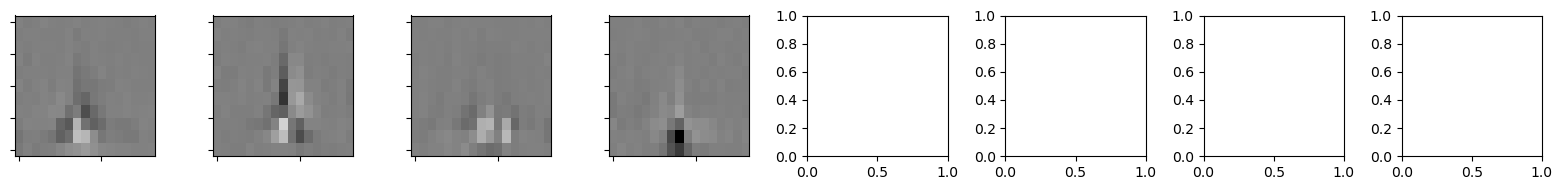

In [29]:
model_edget0.NDN.plot_filters()

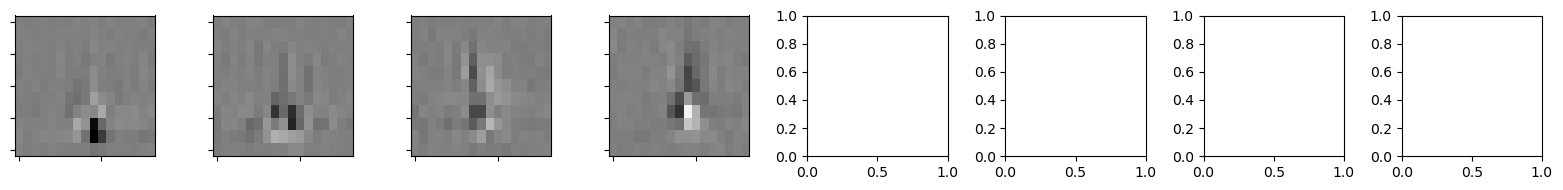

In [30]:
model_none.NDN.plot_filters()

In [7]:
model_none.networks[0].layers[1].weights.shape

(4, 17, 16)

# readout weights

(68, 111)
(68, 111)


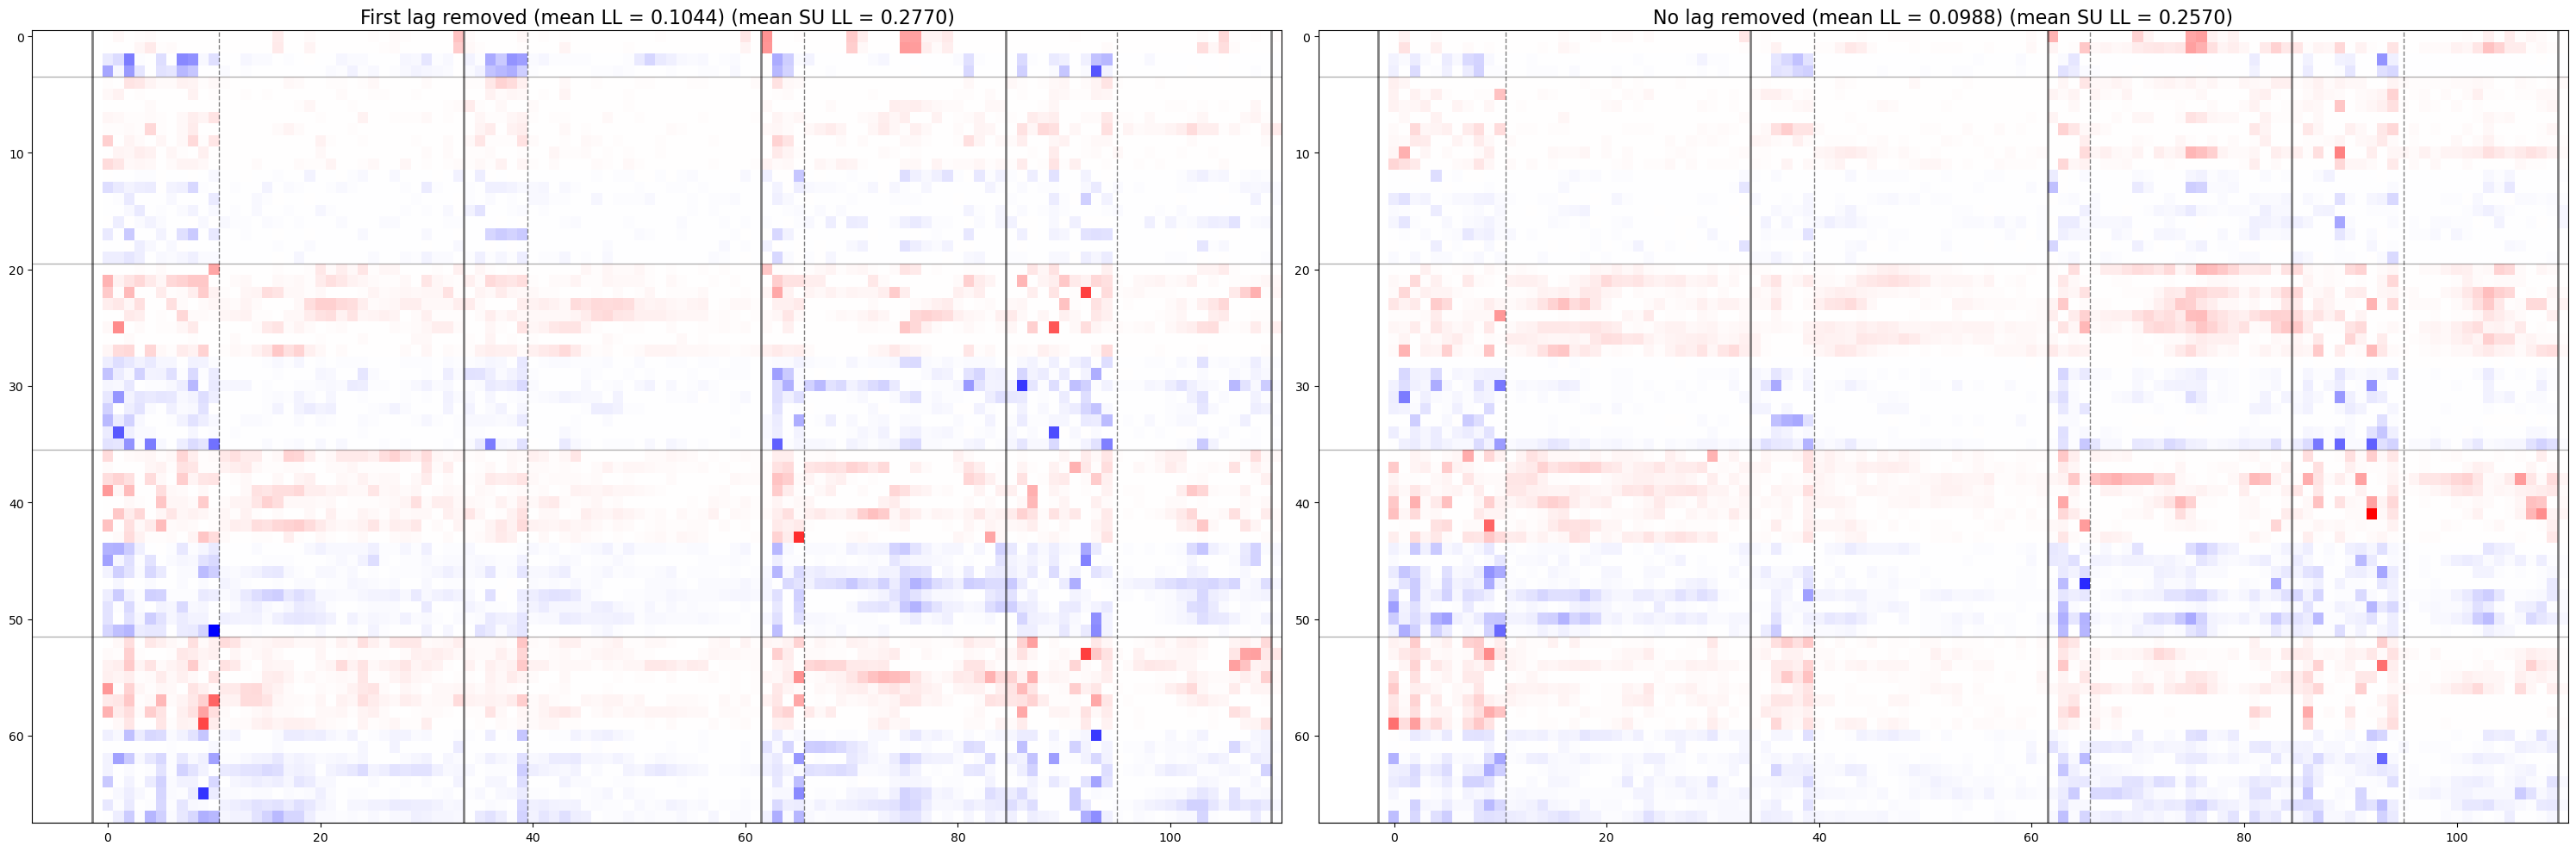

In [31]:
names = ['First lag removed', 'No lag removed']
fig = plt.figure(figsize=(30,10))
for j, trial in enumerate(e.trials[:2]):
    ax = plt.subplot(1,2,j+1)
    readout_weights = np.sum(trial.model.networks[-1].layers[-1].weights[:,:,:], axis=1)
    print(readout_weights.shape)
    # make inhibitory weights negative (every 12 weights need to be flipped)
    readout_weights[2:4,:] = -readout_weights[2:4,:]
    for i in range(12,readout_weights.shape[0],16):
        readout_weights[i:i+8,:] = -readout_weights[i:i+8,:]
    
    # get the mean LLs for just the SUs in k
    mean_SU_LLs = np.mean(trial.LLs[dataset.SUs])
    
    # get the mean LLs for k
    mean_LLs = np.mean(trial.LLs)
    
    plot.imagesc(readout_weights, ax=ax, cmap='bwr', colrow=False, origin='upper')
    ax.set_title(names[j] + ' (mean LL = %.4f)' % mean_LLs + ' (mean SU LL = %.4f)' % mean_SU_LLs, fontsize=16)
    #ax.axis('off')
    
    # put a vertical line between each experiment
    for expt_boundary in expt_boundaries:
        plt.axvline(expt_boundary-1-0.5, color='k', linewidth=2, alpha=0.5)
    
    # put a vertical line between the SUs and the MUs
    # get the indices of the SUs where the experiment boundaries are
    SU_boundaries = np.where(np.diff(dataset.SUs) > 1)[0]
    
    for SU_boundary in SU_boundaries:
        ax.axvline(dataset.SUs[SU_boundary]+1-0.5, color='k', linewidth=1, alpha=0.5, linestyle='--')
    # plot the last SU boundary
    plt.axvline(dataset.SUs[-1]+1, color='k', linewidth=1, alpha=0.5, linestyle='--')
    
    layer_boundaries = [0, 4, 20, 36, 52, 68, 84]
    
    # put a horizontal line between each layer
    for layer_boundary in layer_boundaries[1:-1]:
        ax.axhline(layer_boundary-0.5, color='k', linewidth=1, alpha=0.3)
    
plt.tight_layout()
plt.show()

# is first lag zero in iter layers? 

In [32]:
model_edget0.NDN.networks[0].layers[2].output_dims

[48, 36, 1, 1]

(17, 11, 4)
(4, 17, 16)
(16, 7, 2, 16)
(16, 7, 2, 16)


Text(0.5, 0.98, 'No lag removed, mean iter filter weights')

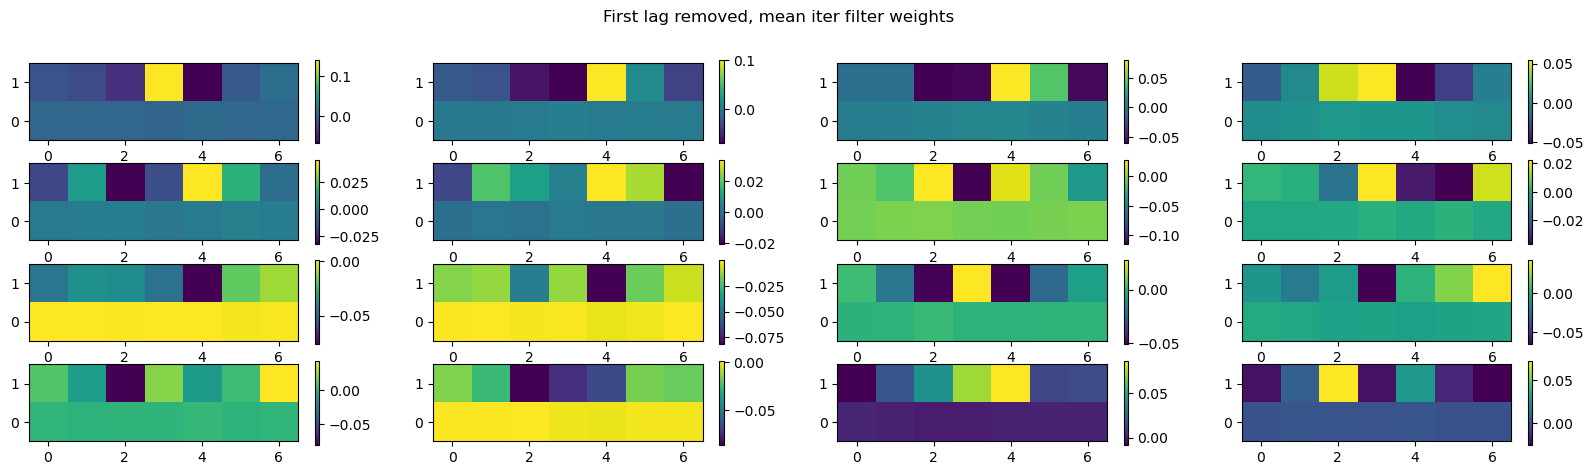

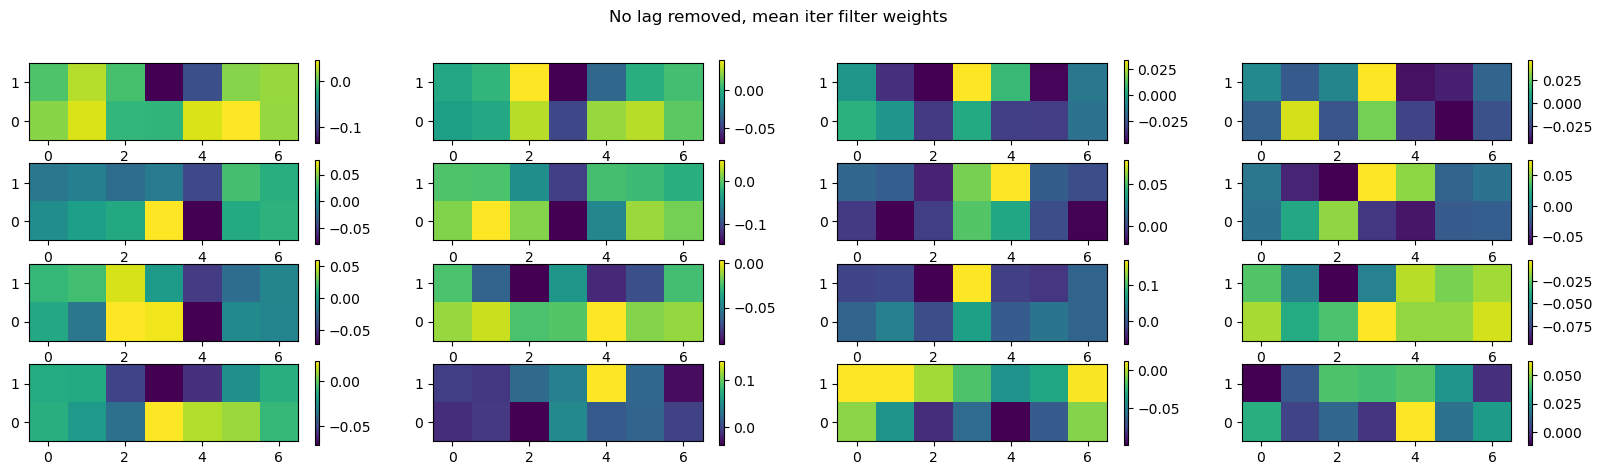

In [33]:
print(model_edget0.networks[0].layers[0].weights.shape)
print(model_edget0.networks[0].layers[1].weights.shape)
print(model_edget0.networks[0].layers[2].weights.shape)
fig = plt.figure(figsize=(20,5))
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    im = ax.imshow(np.mean(model_edget0.networks[0].layers[2].weights[:,:,:,i], axis=0).T, origin='lower')
    # show a colorbar for the axis
    plt.colorbar(im, ax=ax, orientation='vertical')
plt.suptitle('First lag removed, mean iter filter weights')

print(model_none.networks[0].layers[2].weights.shape)
fig = plt.figure(figsize=(20,5))
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    im = ax.imshow(np.mean(model_none.networks[0].layers[2].weights[:,:,:,i], axis=0).T, origin='lower')
    # show a colorbar for the axis
    plt.colorbar(im, ax=ax, orientation='vertical')
plt.suptitle('No lag removed, mean iter filter weights')

# pseudo-jacobian

# jacobians

In [34]:
# look at DSTRFs in the subunits when they are activated
# is the DSTRF higher when the subunit is activated?
# get the outputs for the experiment
end = 100000
results_outputs = predict.predict(model_edget0, dataset=dataset[:end], calc_jacobian=False, verbose=True)

num_inps 100000
prev_output shape torch.Size([100000, 504]) ni 0 NetworkType.scaffold li 0
torch.Size([100000, 504]) --> torch.Size([100000, 576])
prev_output shape torch.Size([100000, 576]) ni 0 NetworkType.scaffold li 1
torch.Size([100000, 576]) --> torch.Size([100000, 2304])
prev_output shape torch.Size([100000, 2304]) ni 0 NetworkType.scaffold li 2
torch.Size([100000, 2304]) --> torch.Size([100000, 1728])
prev_output shape torch.Size([100000, 2448]) ni 1 NetworkType.normal li 0
torch.Size([100000, 2448]) --> torch.Size([100000, 111])


In [35]:
import pickle

class ResultsJacobian:
    def __init__(self, jacobian, times):
        self.jacobian = jacobian
        self.times = times

results_jacobians = []

i = 0
for ni in range(len(results_outputs.outputs)-1): # skip the 'readout' layer
    for li in range(len(results_outputs.outputs[ni])):
        times = []
        num_top = 10000
        num_sample = 10
        if li < 2:
            num_subunits = results_outputs.outputs[ni][li].shape[1]
            for subunit in range(num_subunits):
                if subunit < num_subunits // 2:
                    times = np.argsort(results_outputs.outputs[ni][li][:,subunit,17,0].flatten(), axis=0)[-num_top:]
                else:
                    times = np.argsort(results_outputs.outputs[ni][li][:,subunit,17,0].flatten(), axis=0)[:num_top]
                # randomly sample 10 from the num_top times
                times = np.random.choice(times, num_sample, replace=False)

                jacobian = predict.predict(e.trials[1].model, dataset=dataset[times], calc_jacobian=True, verbose=False, max_network_and_layer=(ni,li))
                results_jacobian = ResultsJacobian(jacobian, times)
                results_jacobians.append(results_jacobian)
                # save the top Jacobians
                # with open('./results_iter_exps14_3iters_jacobians/'+str(i)+'.pkl', 'wb') as f:
                #     pickle.dump(results_jacobian, f)
                i += 1
        else:
            for iter in range(results_outputs.outputs[ni][li].shape[1]):
                num_subunits = results_outputs.outputs[ni][li].shape[2]
                for subunit in range(num_subunits):
                    if subunit < num_subunits // 2:
                        times = np.argsort(results_outputs.outputs[ni][li][:,iter,subunit,17,0].flatten(), axis=0)[-num_top:]
                    else:
                        times = np.argsort(results_outputs.outputs[ni][li][:,iter,subunit,17,0].flatten(), axis=0)[:num_top]
                    # randomly sample 10 from the num_top times
                    times = np.random.choice(times, num_sample, replace=False)

                    jacobian = predict.predict(e.trials[1].model, dataset=dataset[times], calc_jacobian=True, verbose=False, max_network_and_layer=(ni,li))
                    results_jacobian = ResultsJacobian(jacobian, times)
                    results_jacobians.append(results_jacobian)
                    # save the top Jacobians
                    # with open('./results_iter_exps14_3iters_jacobians/'+str(i)+'.pkl', 'wb') as f:
                    #     pickle.dump(results_jacobian, f)
                    i += 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.10it/s]


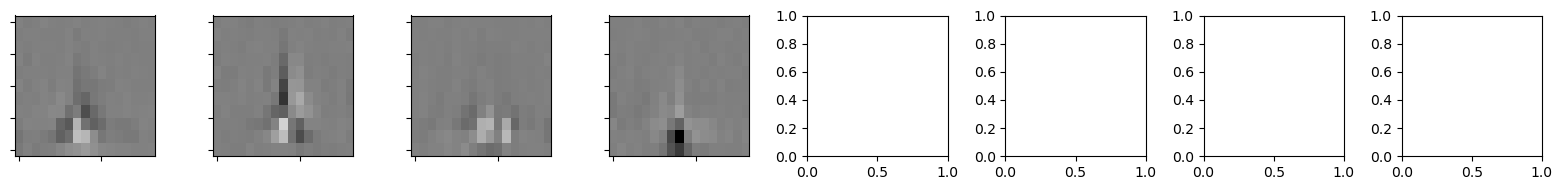

11


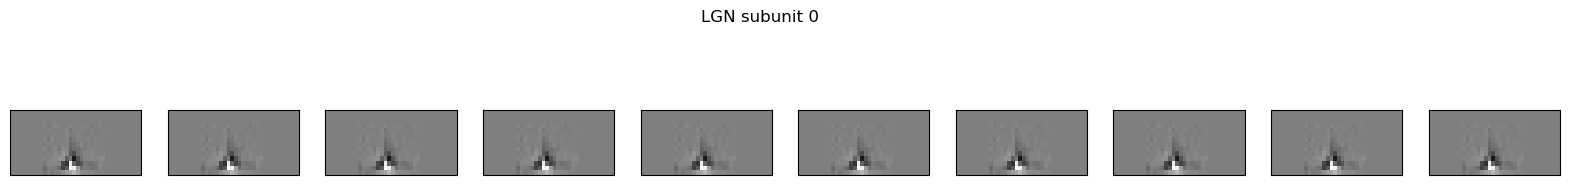

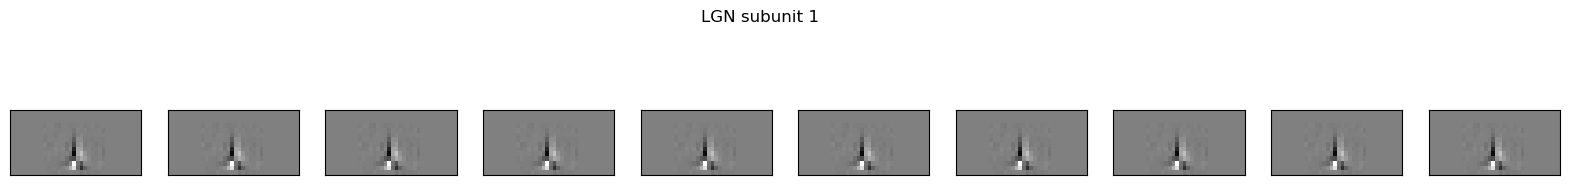

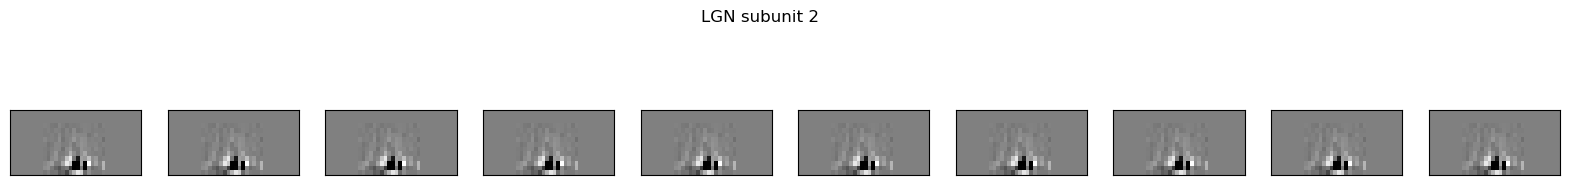

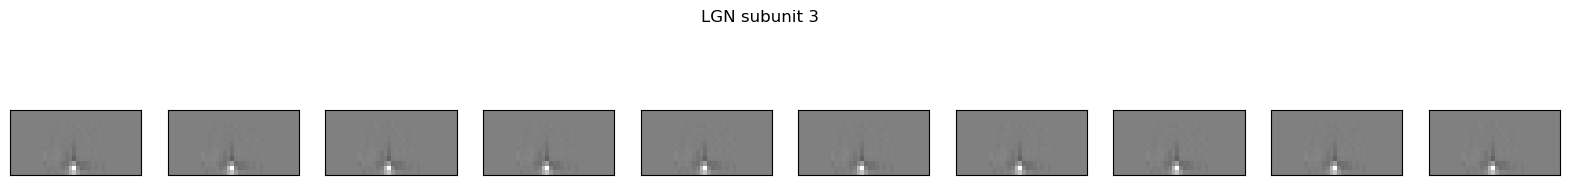

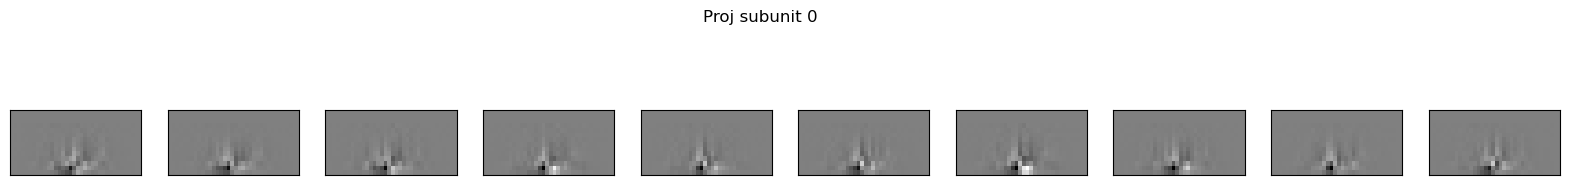

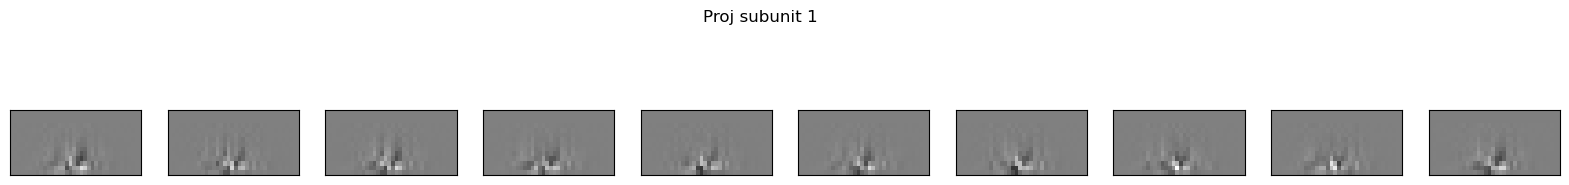

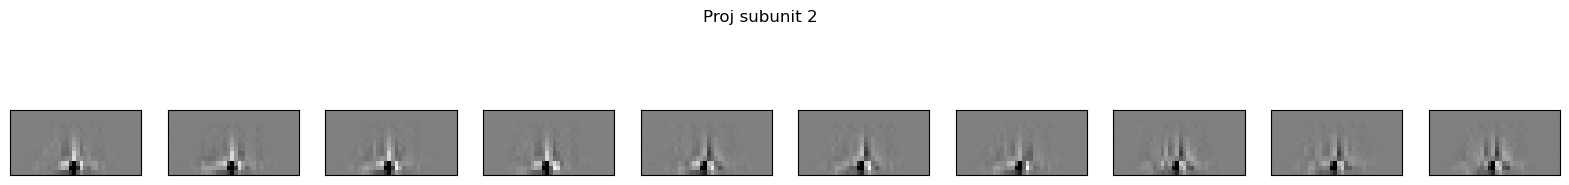

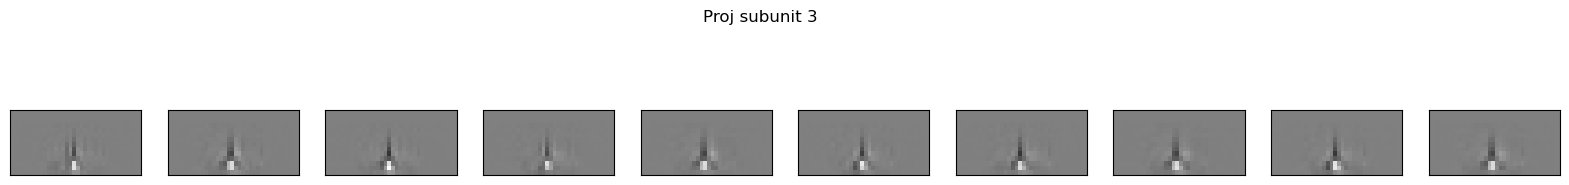

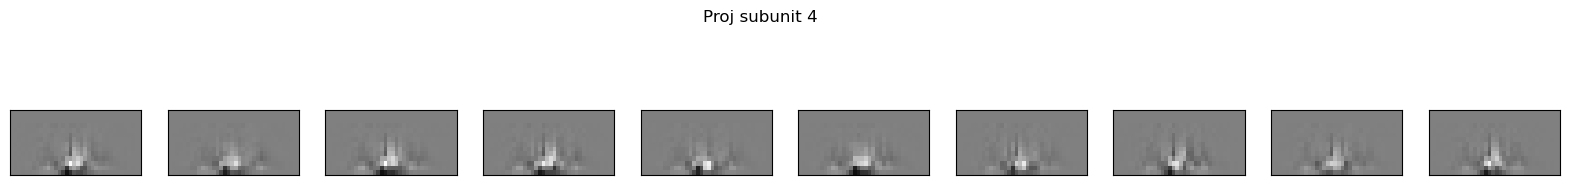

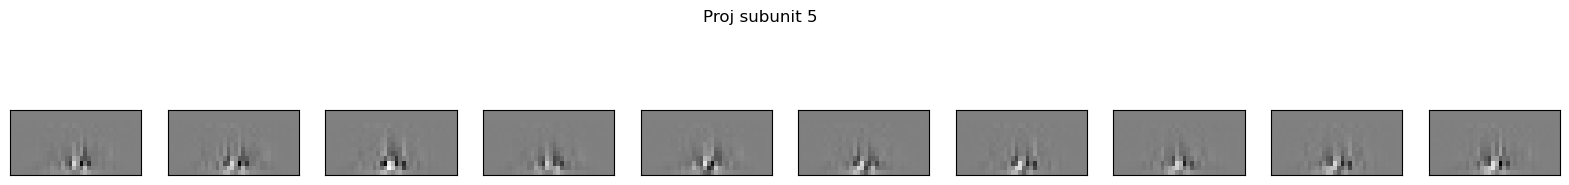

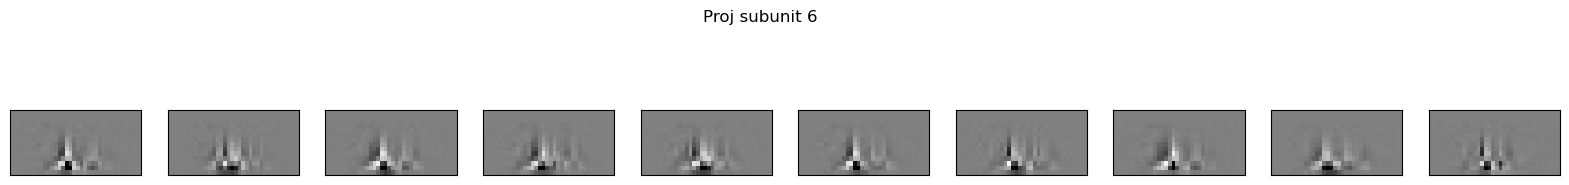

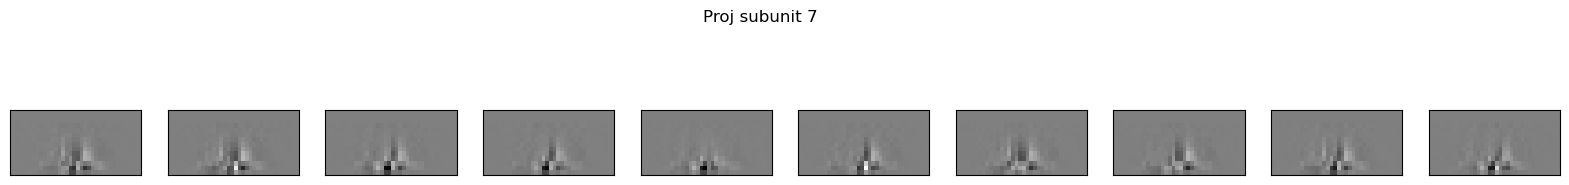

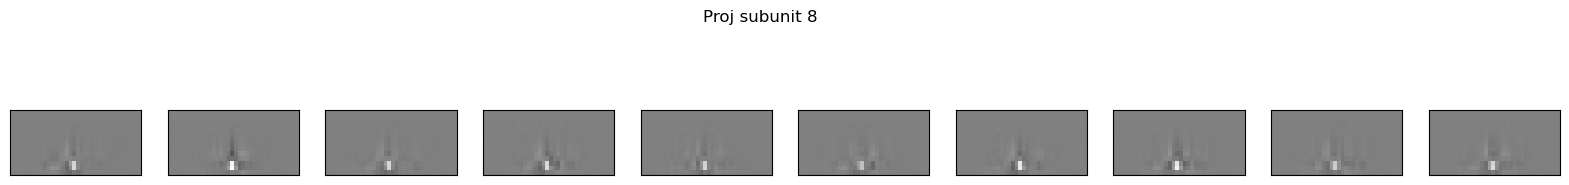

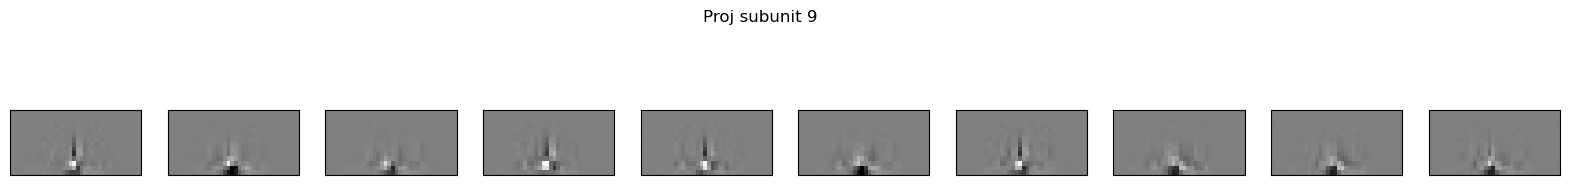

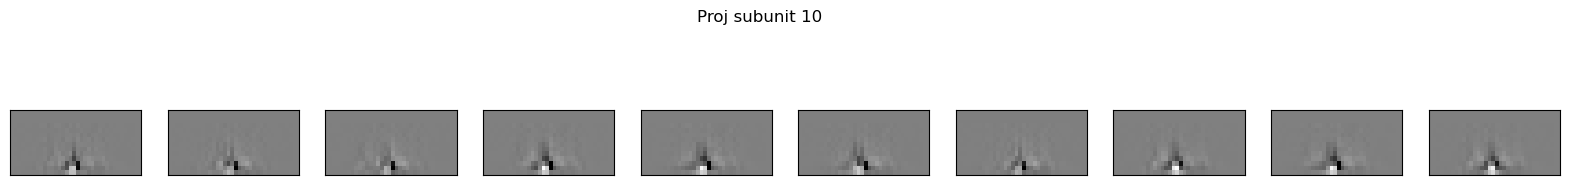

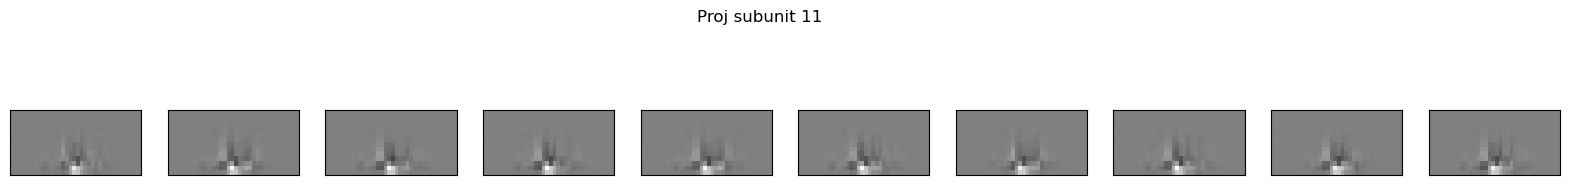

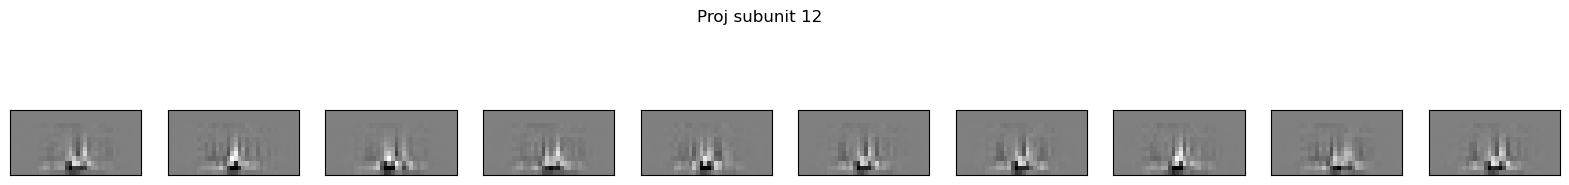

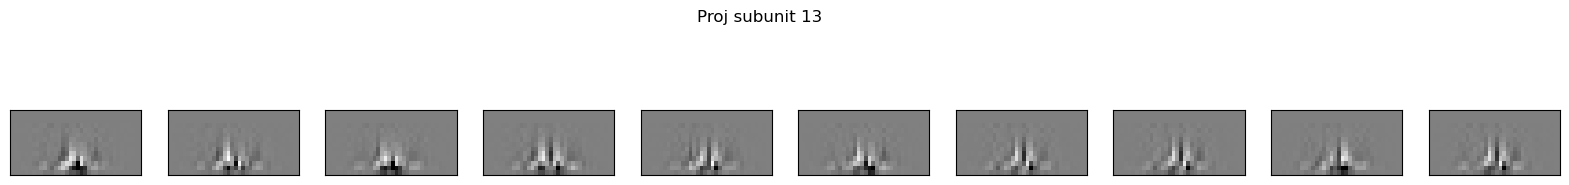

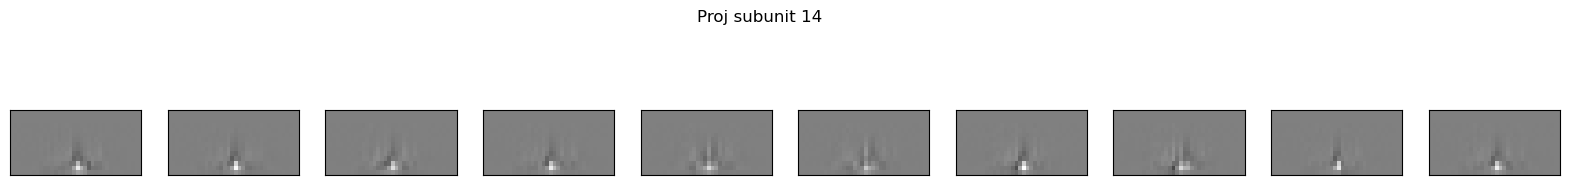

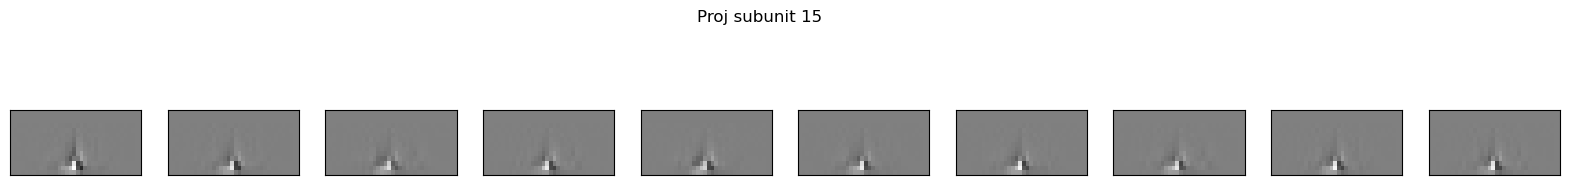

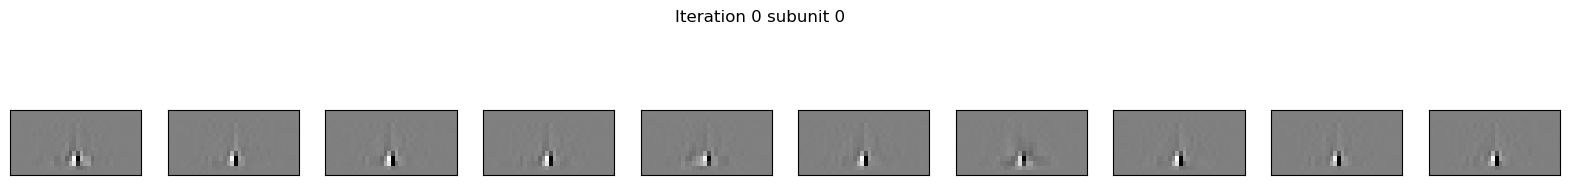

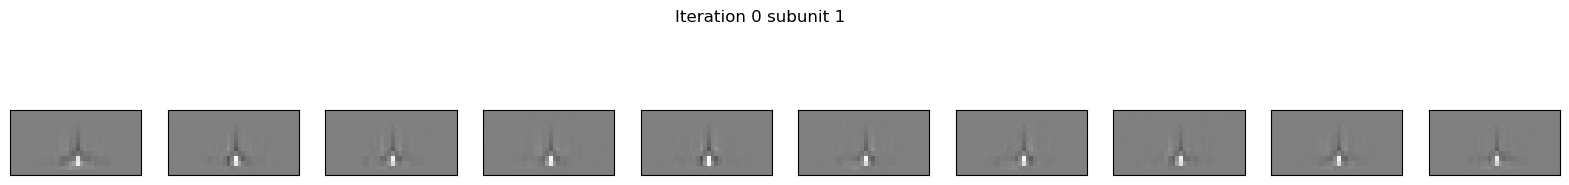

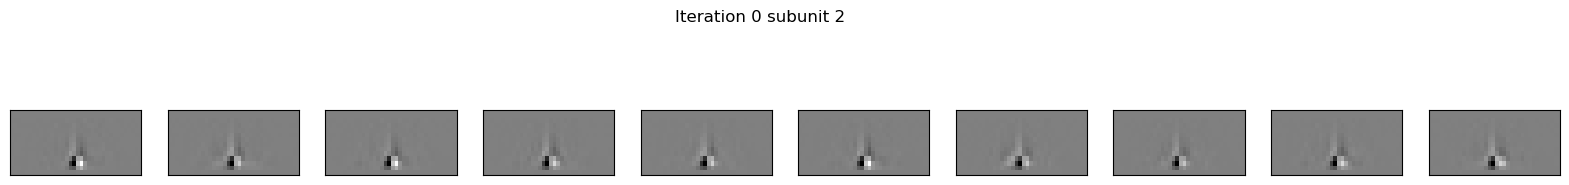

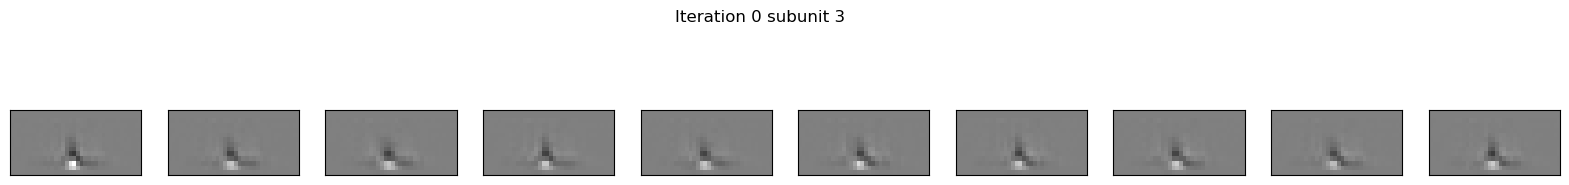

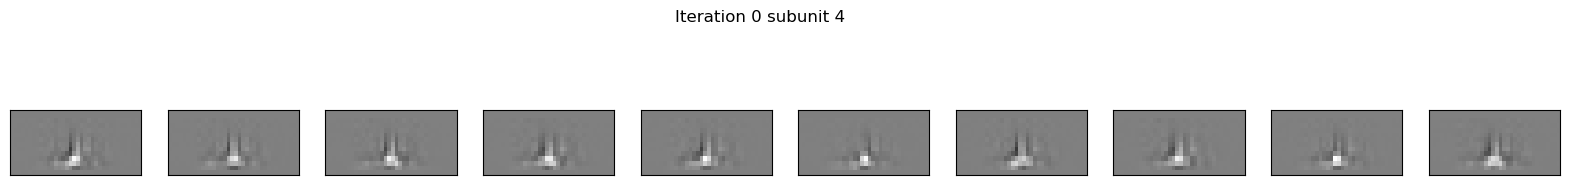

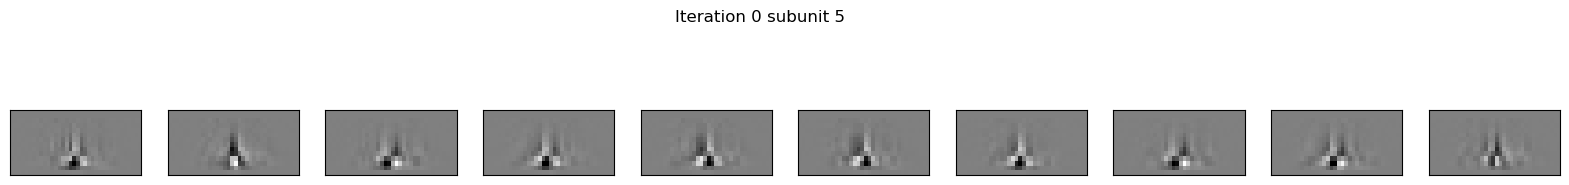

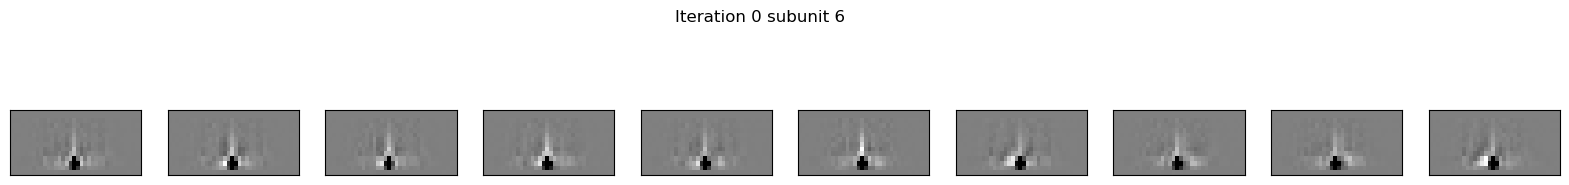

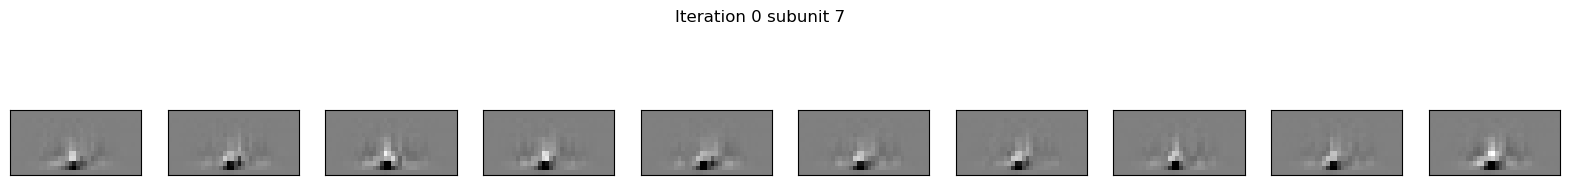

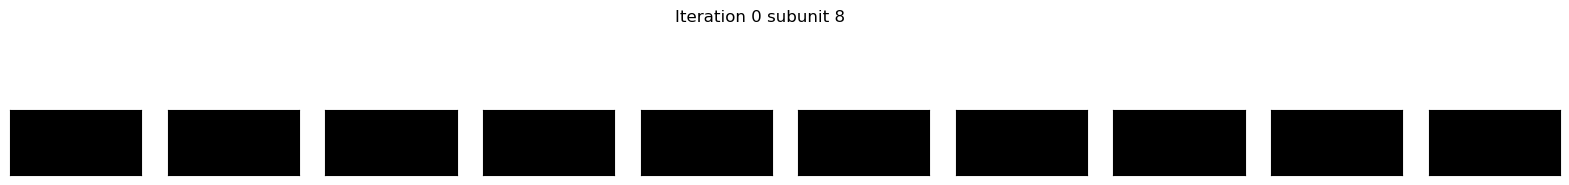

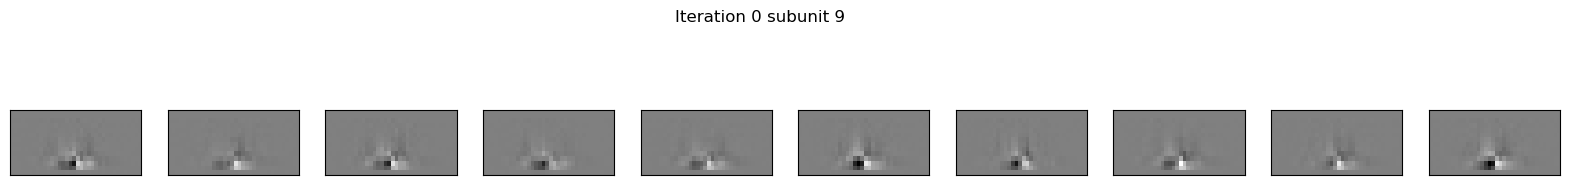

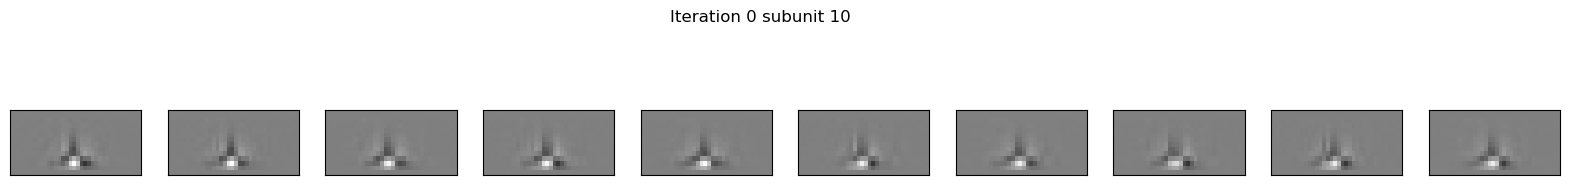

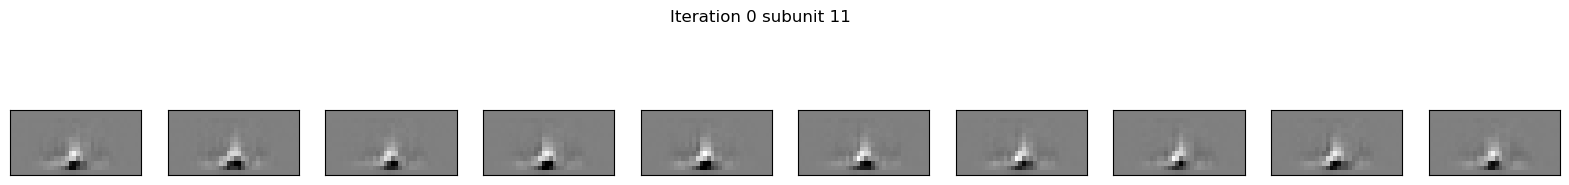

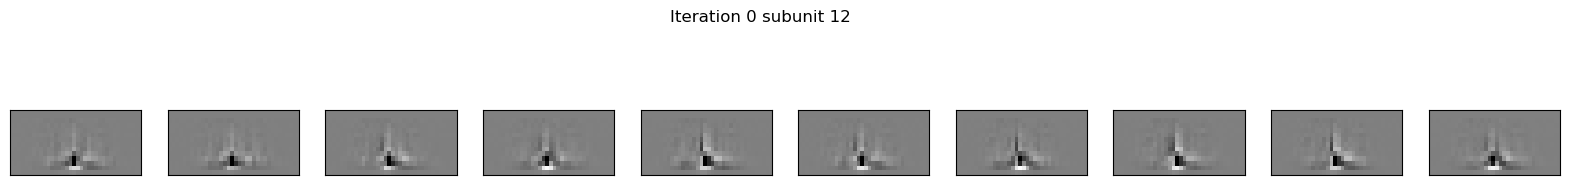

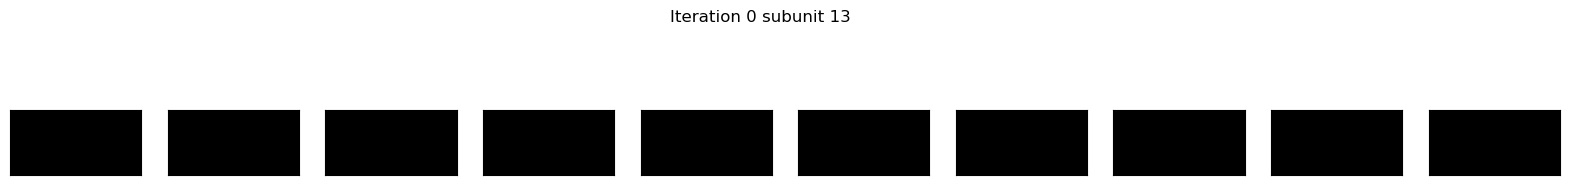

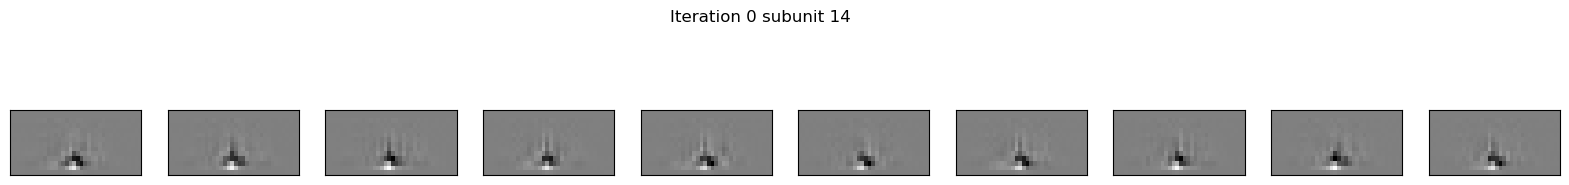

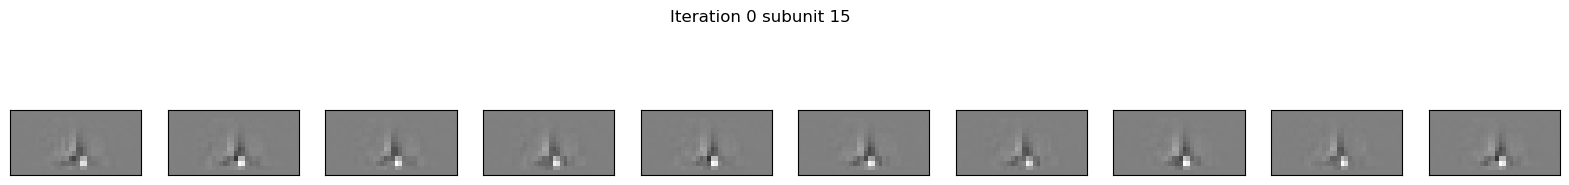

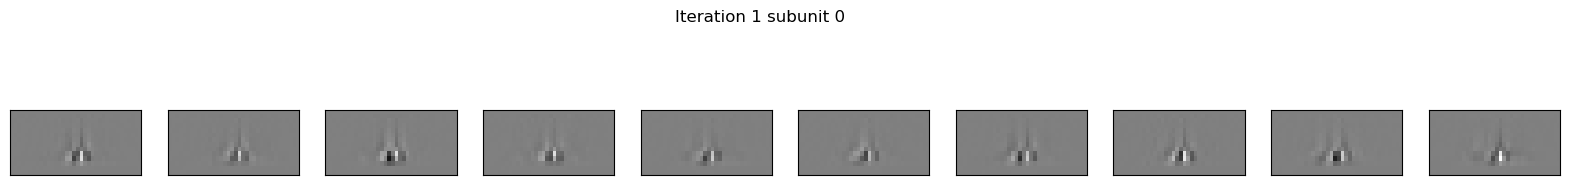

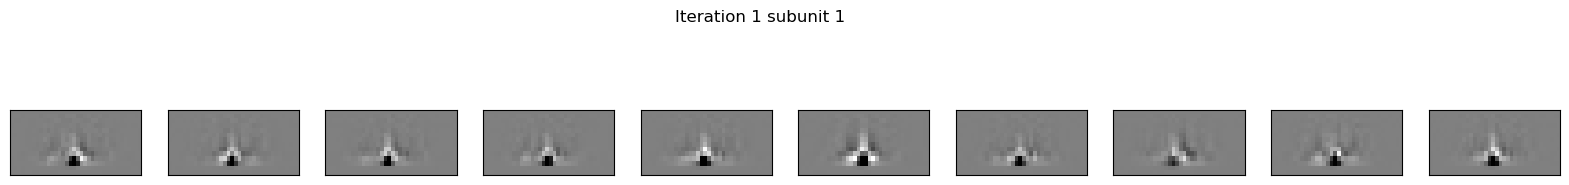

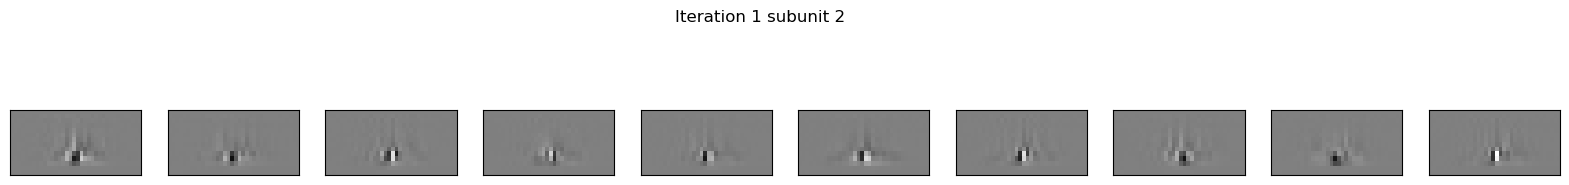

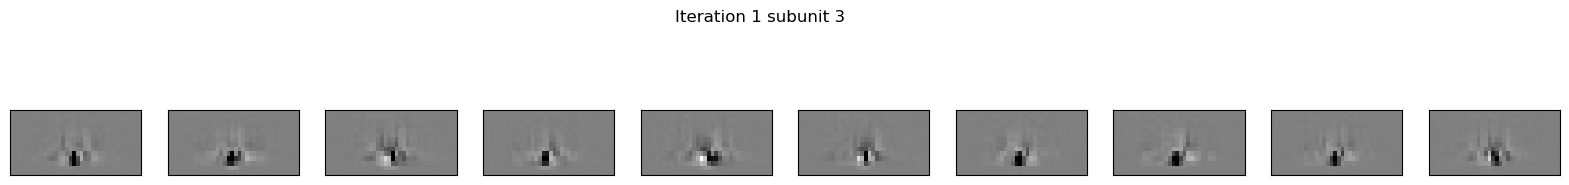

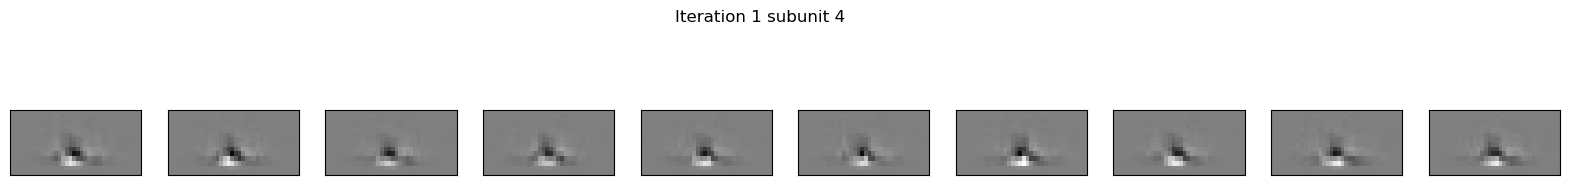

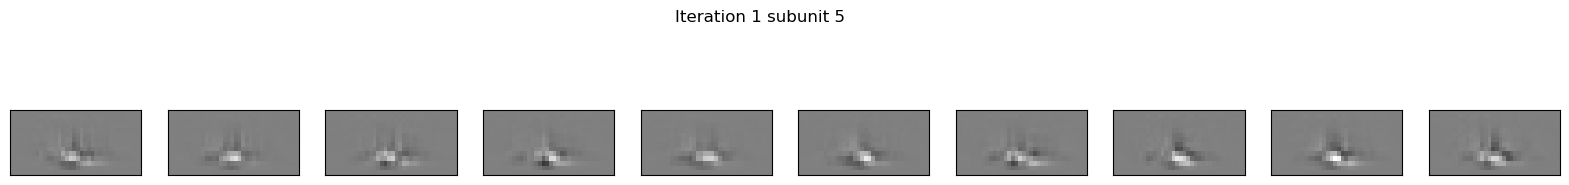

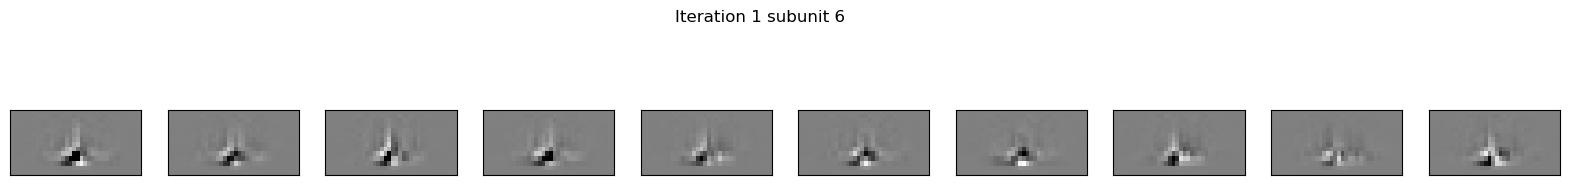

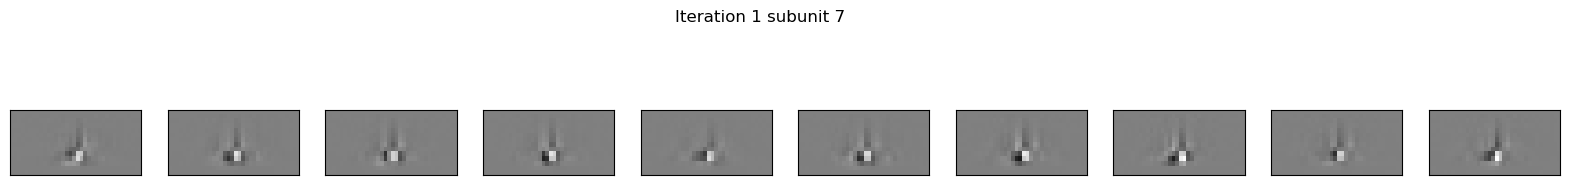

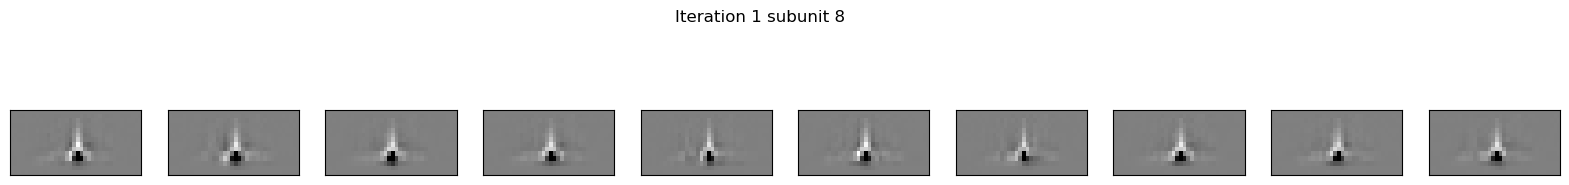

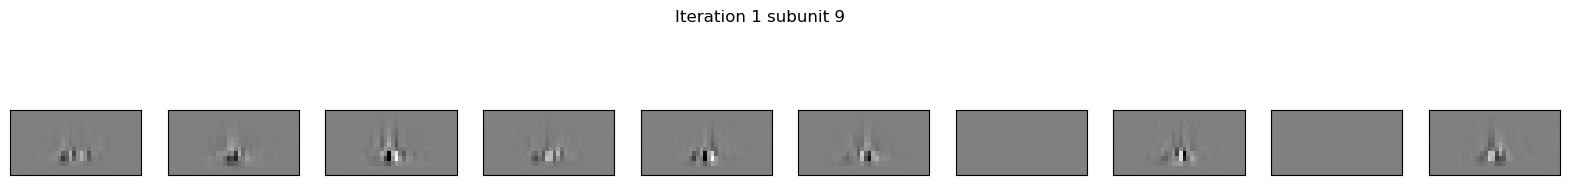

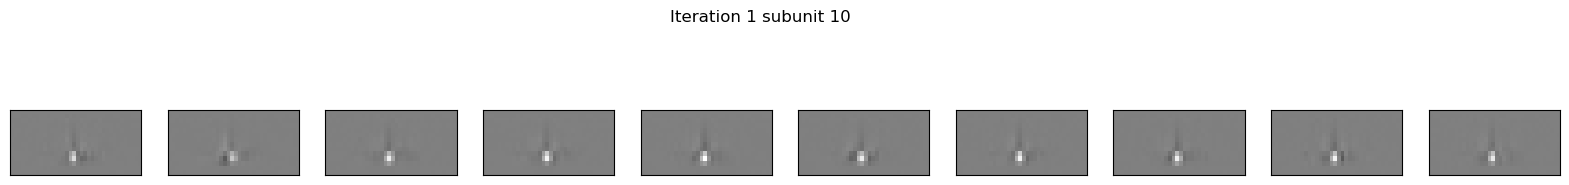

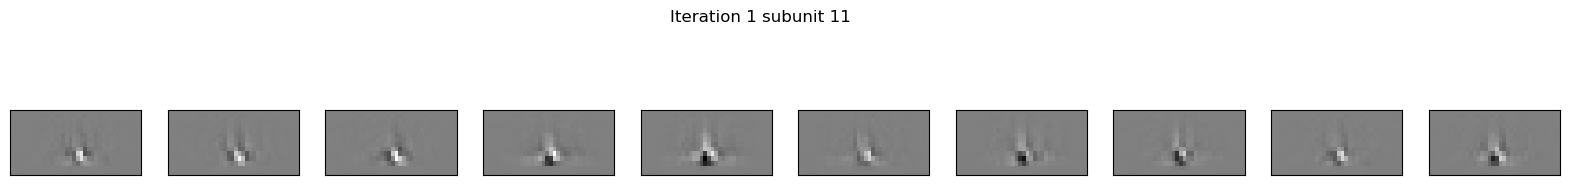

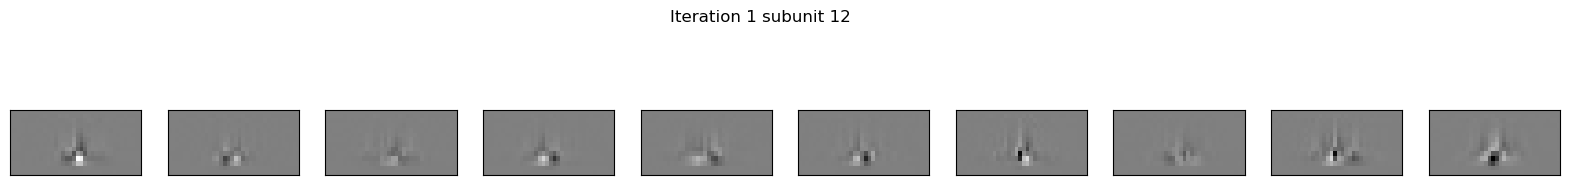

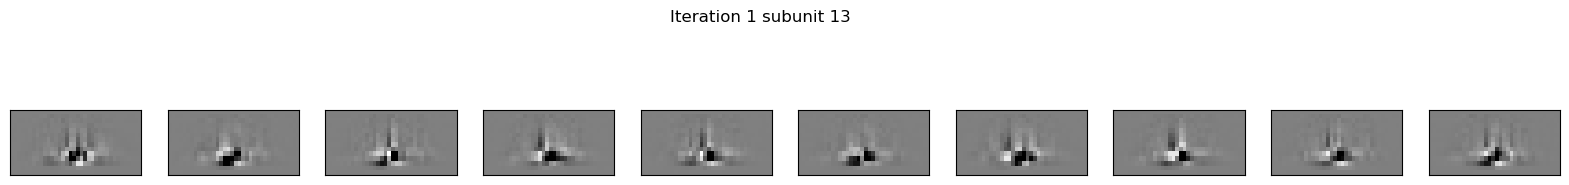

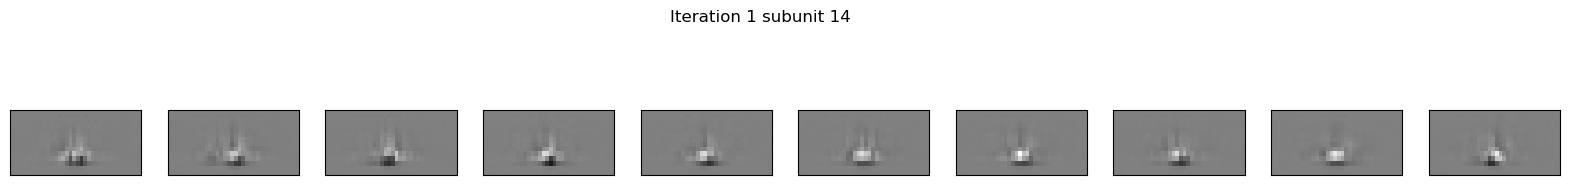

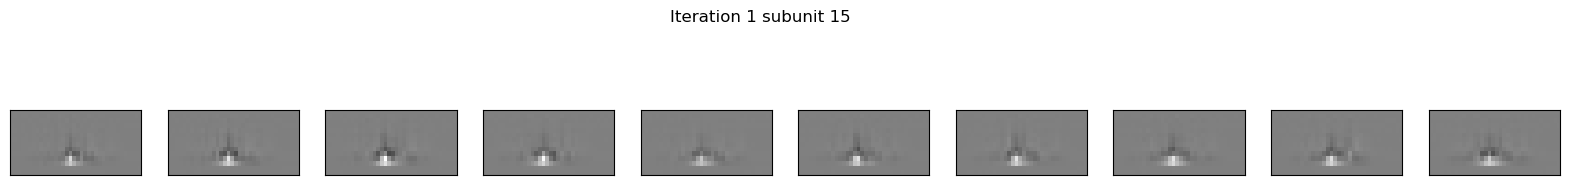

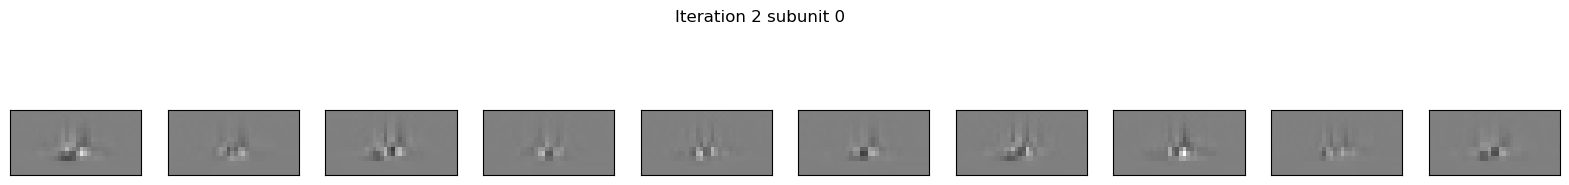

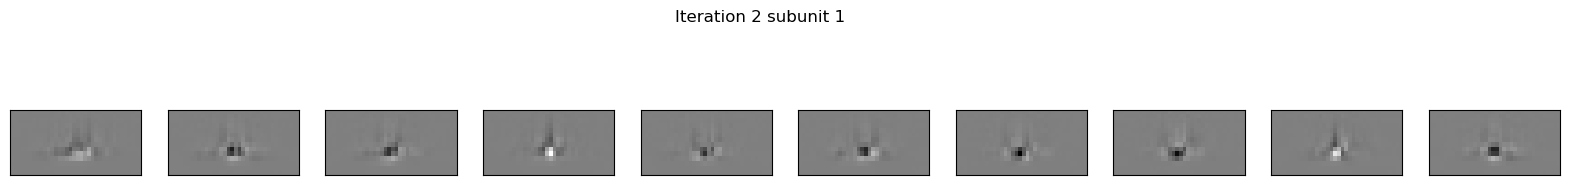

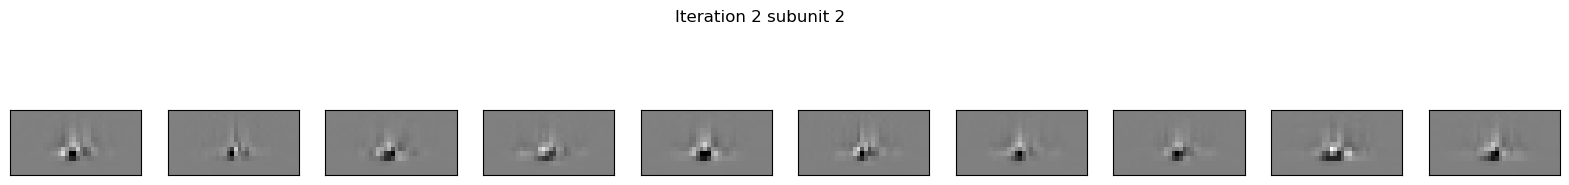

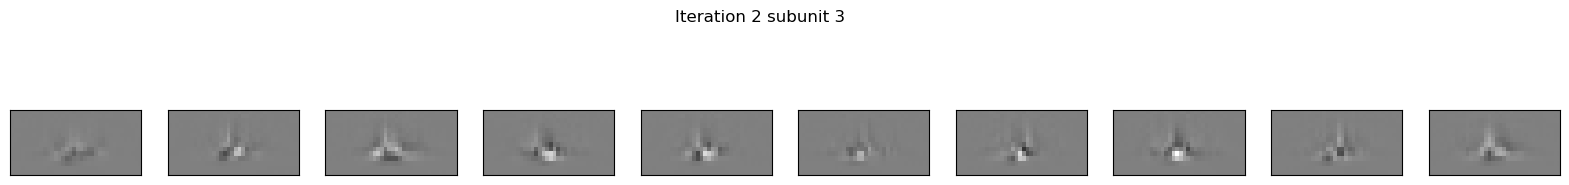

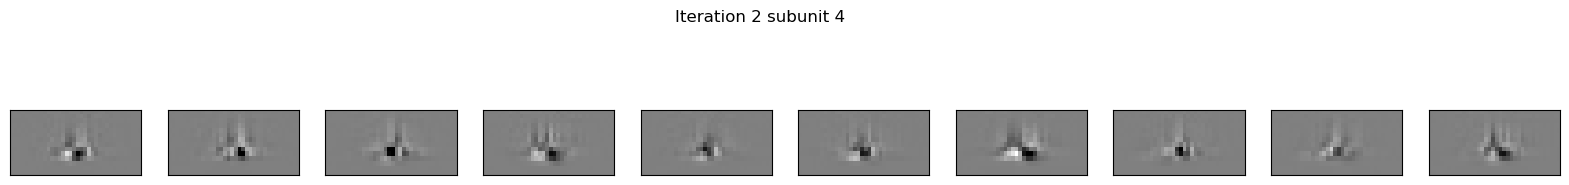

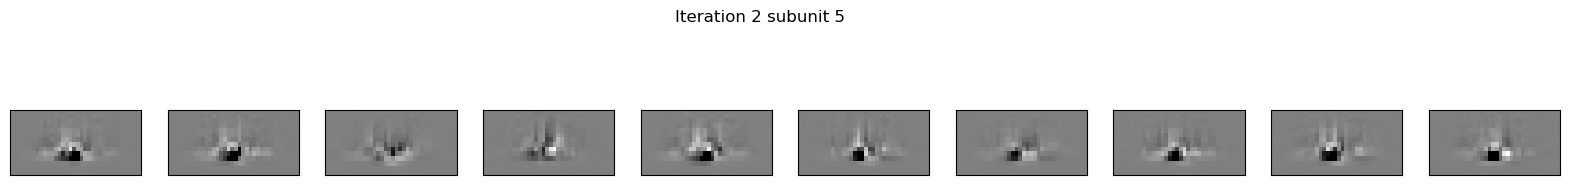

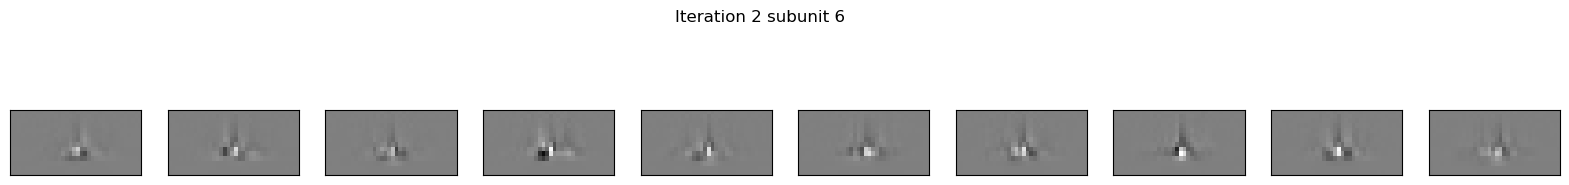

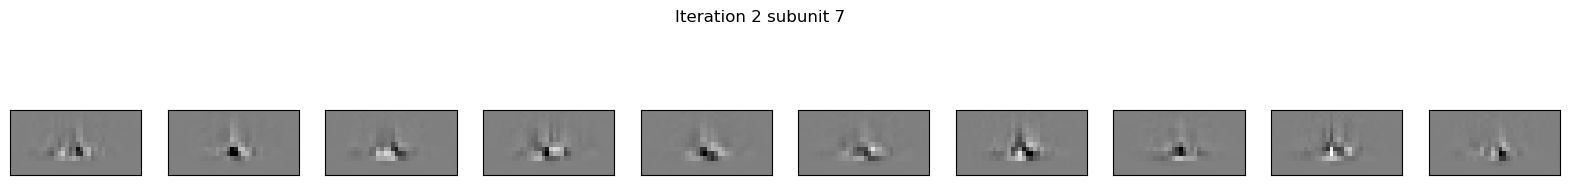

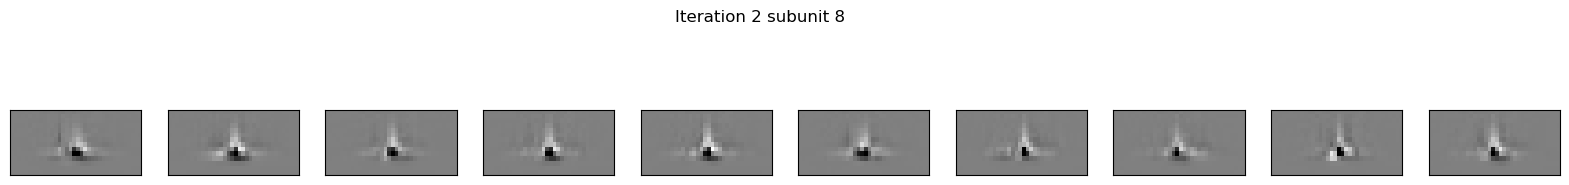

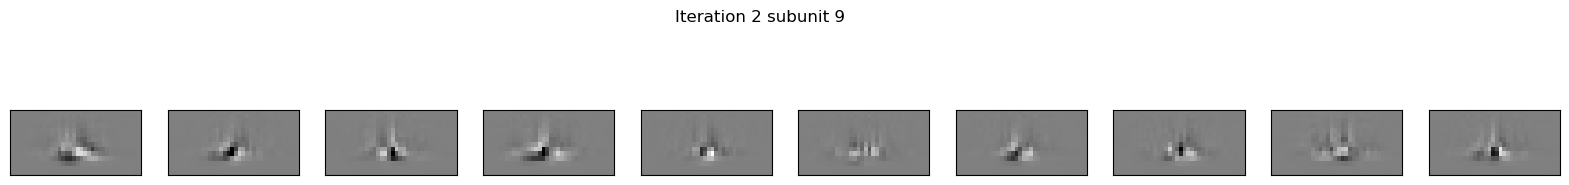

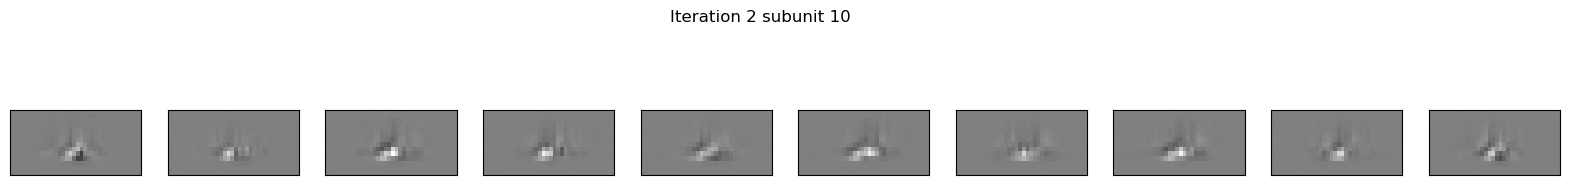

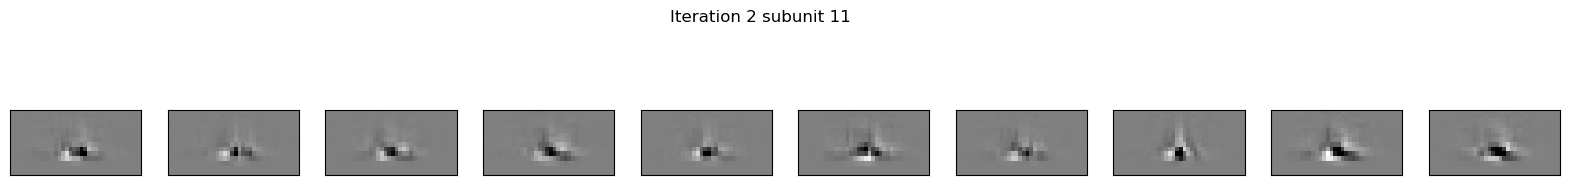

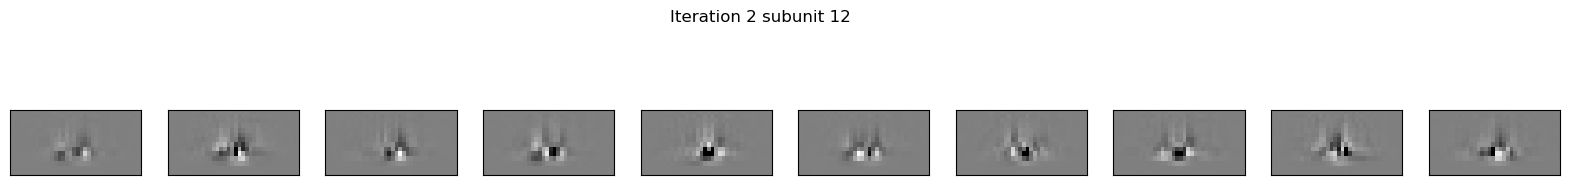

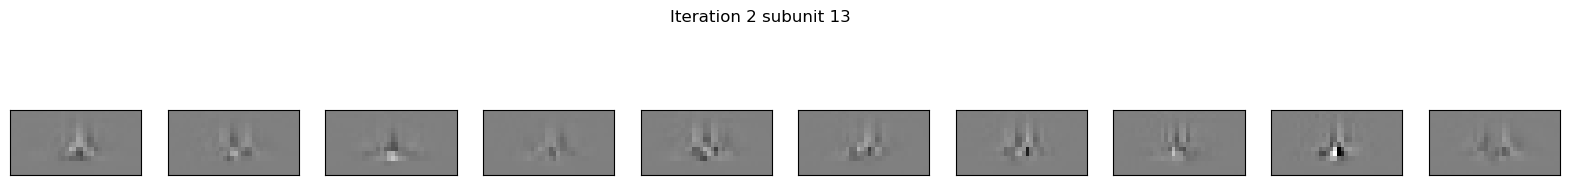

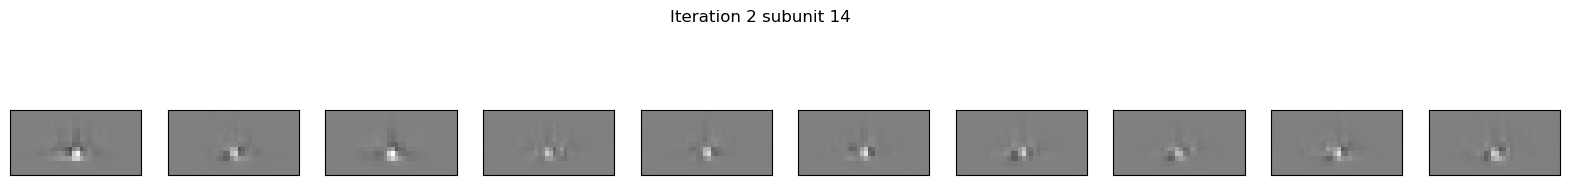

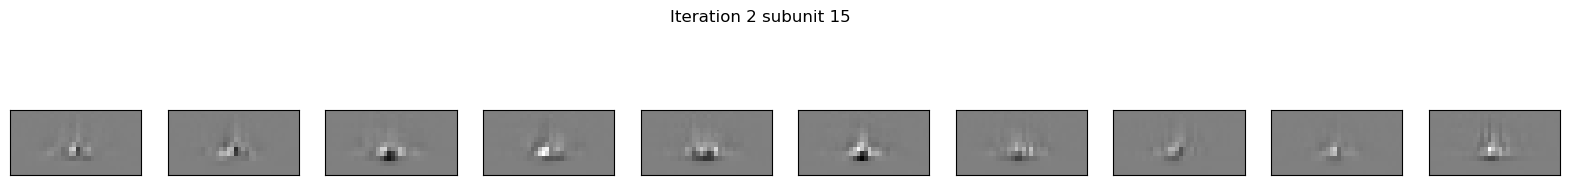

In [42]:
e.trials[1].model.NDN.plot_filters()

cmaps = ['gray', 'Reds', 'Blues', 'Greens', 'Purples', 'Oranges', 'bone', 'copper', 'pink', 'winter', 'autumn']
#cmaps = ['gray'] + plt.colormaps()
print(len(cmaps))

i = 0
for ni in range(len(results_outputs.outputs)-1): # skip the 'readout' layer
    for li in range(len(results_outputs.outputs[ni])):
        #fname = 'ni%d_li%d_subunit%d_jacobians.pkl' % (ni, li, subunit)
        #if os.path.exists('./results_iter_exps12_3iters_jacobians/'+fname):
        #    print('##### Network %d Layer %d Lag %d Subunit %d already done #####' % (ni, li, lag, subunit))
        #    continue # skip if already done
        if li < 2:
            for subunit in range(results_outputs.outputs[ni][li].shape[1]):
                fig = plt.figure(figsize=(20,10))
                grid = matplotlib.gridspec.GridSpec(10,10)
                # plot the results jacobian
                imax = np.max(results_jacobians[i].jacobian.jacobians[0][0][:,subunit,17,0])
                imin = -imax
                for time_idx, time in enumerate(range(results_jacobians[i].jacobian.jacobians[0][0].shape[0])):
                    ax = fig.add_subplot(grid[time_idx])
                    im = results_jacobians[i].jacobian.jacobians[0][0][time,subunit,17,0].reshape(36,14).T
                    ax.imshow(im, aspect='auto', cmap='gray', origin='lower', vmin=imin, vmax=imax)
                    ax.set_xticks([])
                    ax.set_yticks([])
                if li == 0:
                    name = 'LGN'
                elif li == 1:
                    name = 'Proj'
                plt.suptitle(name+' subunit %d' % subunit)
                i += 1
                plt.show()
        else:
            for iter in range(results_outputs.outputs[ni][li].shape[1]):
                for subunit in range(results_outputs.outputs[ni][li].shape[2]):
                    fig = plt.figure(figsize=(20,10))
                    grid = matplotlib.gridspec.GridSpec(10,10)
                    imax = np.max(results_jacobians[i].jacobian.jacobians[0][0][:,iter,subunit,17,0])
                    imin = -imax
                    for time_idx, time in enumerate(range(results_jacobians[i].jacobian.jacobians[0][0].shape[0])):
                        ax = fig.add_subplot(grid[time_idx])
                        im = results_jacobians[i].jacobian.jacobians[0][0][time,iter,subunit,17,0].reshape(36,14).T
                        ax.imshow(im, aspect='auto', cmap='gray', origin='lower', vmin=imin, vmax=imax)
                        ax.set_xticks([])
                        ax.set_yticks([])
                        #ax.set_title(labels[time])
                    plt.suptitle('Iteration %d subunit %d' % (iter, subunit))
                    i += 1
                    plt.show()

In [37]:
# measure spatial and temporal extents of subunits
lgn = []
proj = []
iter0 = []
iter1 = []
iter2 = []
#iter3 = []
#iter4 = []
for idx,i in enumerate(range(68)):
    if i < 4: # it is not-iterative
        lgn.append(results_jacobians[i].jacobian.jacobians[0][0][:,i,17,0])
    elif i < 20:
        proj.append(results_jacobians[i].jacobian.jacobians[0][0][:,i-4,17,0])
    elif i < 36:
        iter0.append(results_jacobians[i].jacobian.jacobians[0][0][:,0,i-20,17,0])
    elif i < 52:
        iter1.append(results_jacobians[i].jacobian.jacobians[0][0][:,1,i-36,17,0])
    elif i < 68:
        iter2.append(results_jacobians[i].jacobian.jacobians[0][0][:,2,i-52,17,0])
    # elif i < 84:
    #     iter3.append(results_jacobians[i].jacobian.jacobians[0][0][:,3,i-68,17,0])
    # elif i < 100:
    #     iter4.append(results_jacobians[i].jacobian.jacobians[0][0][:,4,i-84,17,0])

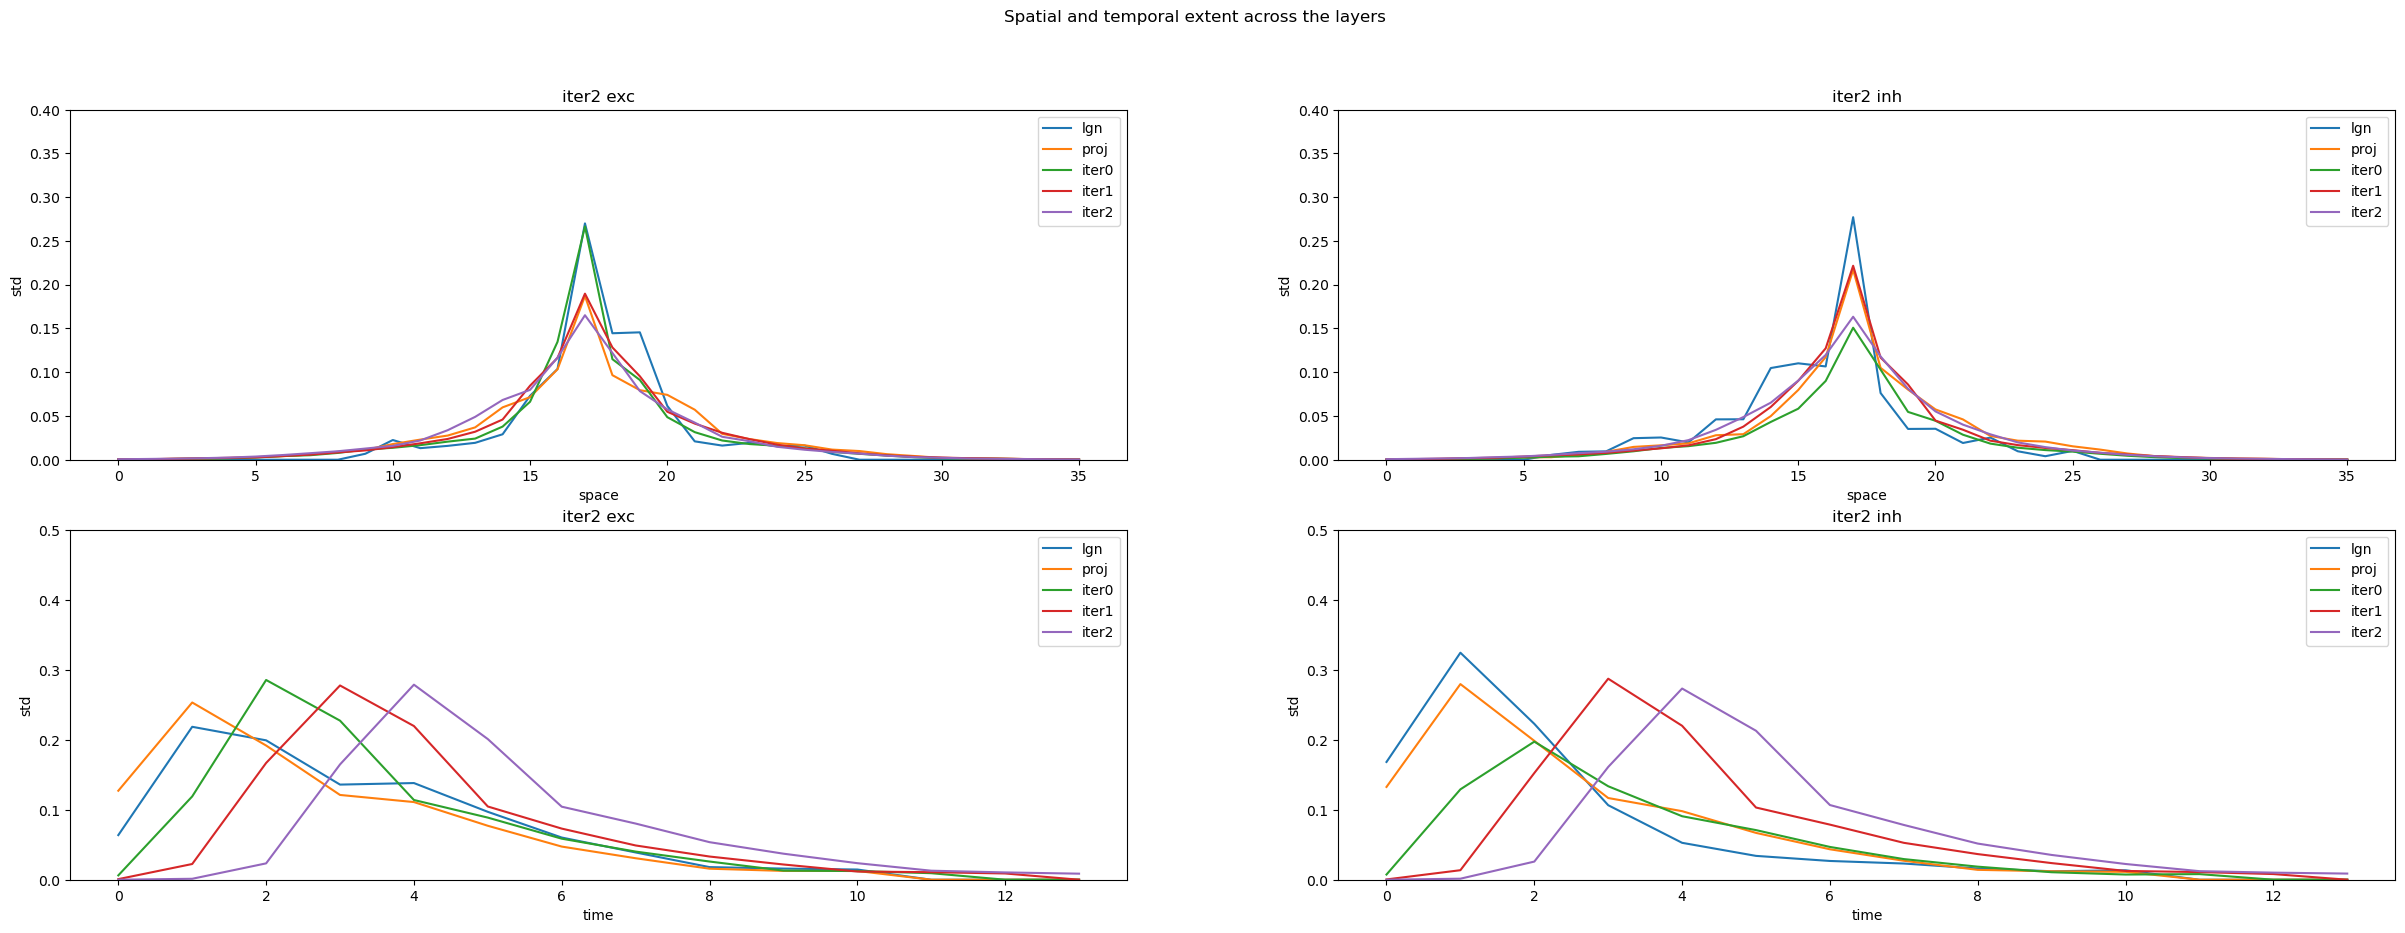

In [43]:
fig = plt.figure(figsize=(30,10))
grid = matplotlib.gridspec.GridSpec(2,2)
ax0 = fig.add_subplot(grid[0,0])
ax1 = fig.add_subplot(grid[0,1])
ax2 = fig.add_subplot(grid[1,0])
ax3 = fig.add_subplot(grid[1,1])
layer_idx = 0
for ims,name in zip([lgn, proj, iter0, iter1, iter2], ['lgn', 'proj', 'iter0', 'iter1', 'iter2']):
    ws = []
    hs = []
    ksps = []
    for i in range(len(ims)//2):
        im = ims[i].reshape(10,36,14)
        ksp = np.mean(np.std(im, axis=2), axis=0)
        ksp = ksp / (np.sum(ksp) + 0.000001)
        # find the max and shift the ksp so that the max is at 17
        max_idx = np.argmax(ksp)
        ksp = np.roll(ksp, 17-max_idx)
        if max_idx > 17:
            ksp[17-max_idx:] = 0 # set the rolled off part to 0
        else:
            ksp[:17-max_idx] = 0 # set the rolled off part to 0
        ksps.append(ksp)
    ax0.plot(np.mean(ksps, axis=0), label=name)
    ax0.set_title(name + ' exc')
    ax0.set_xlabel('space')
    ax0.set_ylabel('std')
    ax0.set_ylim([0,0.4])
    ax0.legend()

    ksps = []
    for i in range(len(ims)//2, len(ims)):
        im = ims[i].reshape(10,36,14)
        ksp = np.mean(np.std(im, axis=2), axis=0)
        ksp = ksp / (np.sum(ksp) + 0.000001)
        # find the max and shift the ksp so that the max is at 17
        max_idx = np.argmax(ksp)
        ksp = np.roll(ksp, 17-max_idx)
        if max_idx > 17:
            ksp[17-max_idx:] = 0 # set the rolled off part to 0
        else:
            ksp[:17-max_idx] = 0 # set the rolled off part to 0
        ksps.append(ksp)
    ax1.plot(np.mean(ksps, axis=0), label=name)
    ax1.set_title(name + ' inh')
    ax1.set_xlabel('space')
    ax1.set_ylabel('std')
    ax1.set_ylim([0,0.4])
    ax1.legend()

    kts = []
    for i in range(len(ims)//2):
        im = ims[i].reshape(10,36,14)
        kt = np.mean(np.std(im, axis=1), axis=0)
        kt = kt / (np.sum(kt) + 0.000001)
        kts.append(kt)
    ax2.plot(np.mean(kts, axis=0), label=name)
    ax2.set_title(name + ' exc')
    ax2.set_xlabel('time')
    ax2.set_ylabel('std')
    ax2.set_ylim([0,0.5])
    ax2.legend()

    kts = []
    for i in range(len(ims)//2, len(ims)):
        im = ims[i].reshape(10,36,14)
        kt = np.mean(np.std(im, axis=1), axis=0)
        kt = kt / (np.sum(kt) + 0.000001)
        kts.append(kt)
    ax3.plot(np.mean(kts, axis=0), label=name)
    ax3.set_title(name + ' inh')
    ax3.set_xlabel('time')
    ax3.set_ylabel('std')
    ax3.set_ylim([0,0.5])
    ax3.legend()
    plt.suptitle(name)
    layer_idx += 2
_ = plt.suptitle('Spatial and temporal extent across the layers')

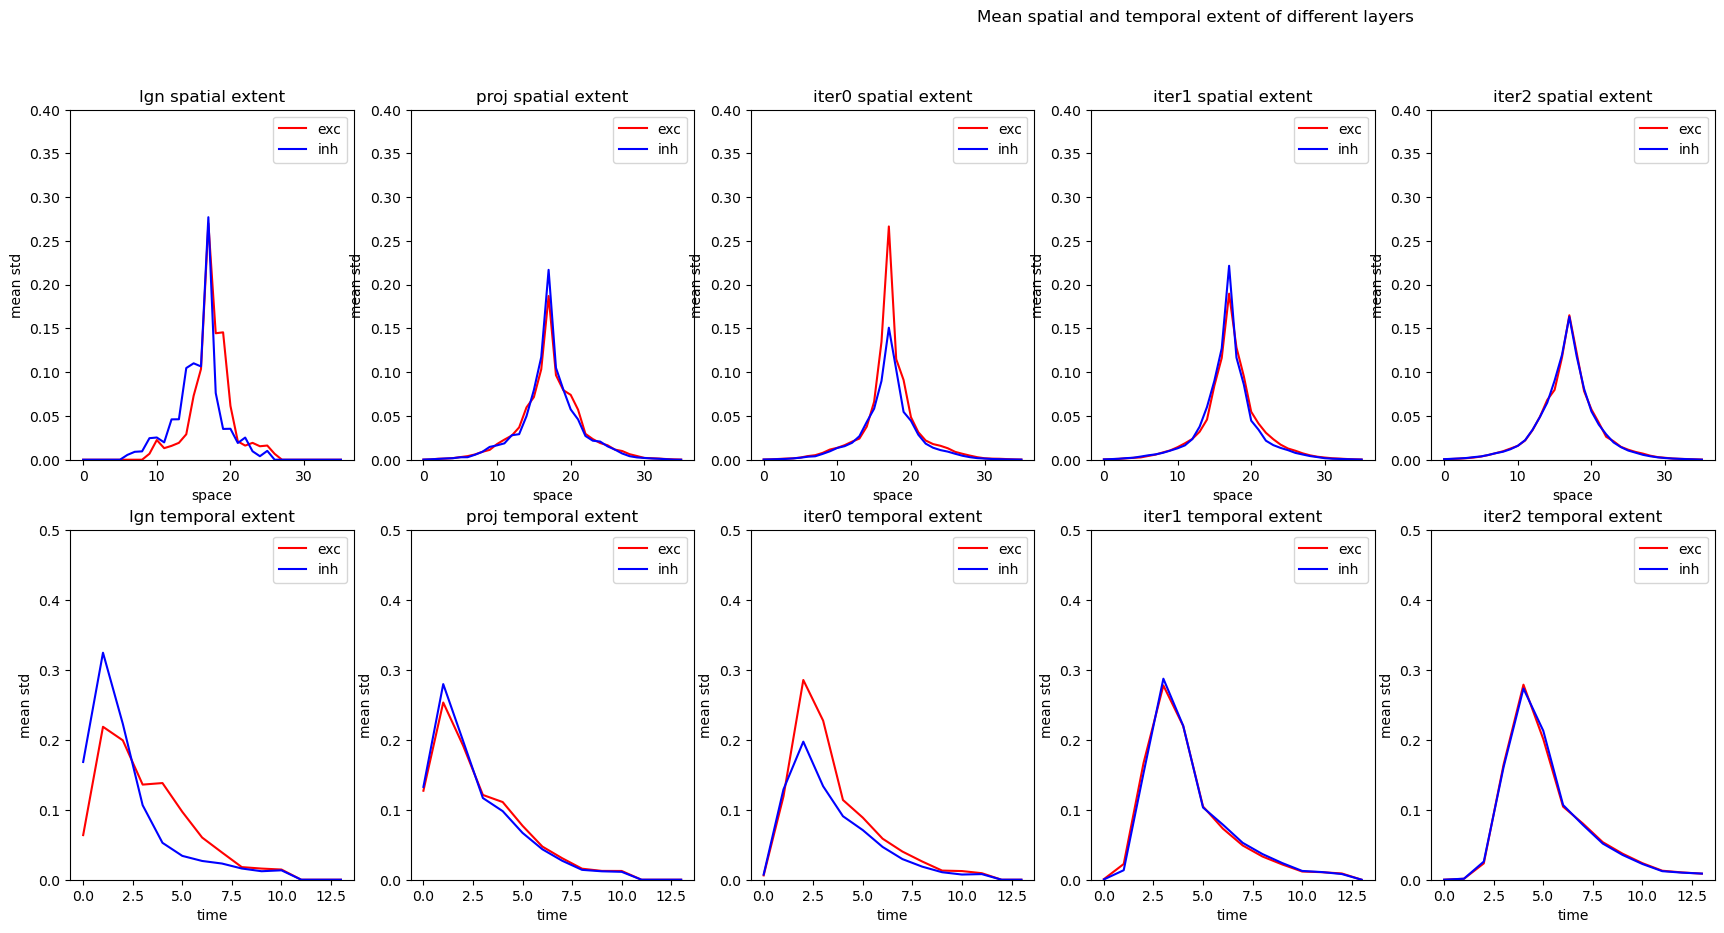

In [44]:
fig = plt.figure(figsize=(30,10))
grid = matplotlib.gridspec.GridSpec(2,7)
layer_idx = 0
for ims,name in zip([lgn, proj, iter0, iter1, iter2], ['lgn', 'proj', 'iter0', 'iter1', 'iter2']):
    ws = []
    hs = []
    ksps = []
    ax = fig.add_subplot(grid[0,layer_idx])
    for i in range(len(ims)//2):
        im = ims[i].reshape(10,36,14)
        ksp = np.mean(np.std(im, axis=2), axis=0)
        ksp = ksp / (np.sum(ksp) + 0.000001)
        # find the max and shift the ksp so that the max is at 17
        max_idx = np.argmax(ksp)
        ksp = np.roll(ksp, 17-max_idx)
        if max_idx > 17:
            ksp[17-max_idx:] = 0 # set the rolled off part to 0
        else:
            ksp[:17-max_idx] = 0 # set the rolled off part to 0
        ksps.append(ksp)
    ax.plot(np.mean(ksps, axis=0), c='r', label='exc')
    ax.set_title(name + ' spatial extent')
    ax.set_xlabel('space')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.4])
    ax.legend()

    ksps = []
    for i in range(len(ims)//2, len(ims)):
        im = ims[i].reshape(10,36,14)
        ksp = np.mean(np.std(im, axis=2), axis=0)
        ksp = ksp / (np.sum(ksp) + 0.000001)
        # find the max and shift the ksp so that the max is at 17
        max_idx = np.argmax(ksp)
        ksp = np.roll(ksp, 17-max_idx)
        if max_idx > 17:
            ksp[17-max_idx:] = 0 # set the rolled off part to 0
        else:
            ksp[:17-max_idx] = 0 # set the rolled off part to 0
        ksps.append(ksp)
    ax.plot(np.mean(ksps, axis=0), c='b', label='inh')
    ax.set_title(name + ' spatial extent')
    ax.set_xlabel('space')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.4])
    ax.legend()

    kts = []
    ax = fig.add_subplot(grid[1,layer_idx])
    for i in range(len(ims)//2):
        im = ims[i].reshape(10,36,14)
        kt = np.mean(np.std(im, axis=1), axis=0)
        kt = kt / (np.sum(kt) + 0.000001)
        kts.append(kt)
    ax.plot(np.mean(kts, axis=0), c='r', label='exc')
    ax.set_title(name + ' temporal extent')
    ax.set_xlabel('time')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.5])
    ax.legend()

    kts = []
    for i in range(len(ims)//2, len(ims)):
        im = ims[i].reshape(10,36,14)
        kt = np.mean(np.std(im, axis=1), axis=0)
        kt = kt / (np.sum(kt) + 0.000001)
        kts.append(kt)
    ax.plot(np.mean(kts, axis=0), c='b', label='inh')
    ax.set_title(name + ' temporal extent')
    ax.set_xlabel('time')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.5])
    ax.legend()
    layer_idx += 1
_ = plt.suptitle('Mean spatial and temporal extent of different layers')